In [11]:
%precision 3
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from matplotlib import cm
# and we will create some animations!
import matplotlib.animation as animation
from IPython.display import HTML
from pprint import pprint

In [12]:
def pressure_poisson_jacobi(p, dx, dy, RHS, rtol = 1.e-5, logs = False):
    """ Solve the pressure Poisson equation (PPE)
    using Jacobi iteration assuming mesh spacing of
    dx and dy (we assume at the moment that dx=dy)
    and the RHS function given by RHS.
    
    Assumes imposition of a Neumann BC on all boundaries.
    
    Return the pressure field.
    """
    # our code below is only currently for the case dx=dy
    assert dx==dy
    # iterate
    tol = 10.*rtol
    it = 0
    p_old = np.copy(p)
    while tol > rtol:
        #swap arrays without copying the data
        temp = p_old
        p_old = p
        p = temp
        
        it += 1
        p[1:-1, 1:-1] = 0.25*(p_old[2:, 1:-1] + p_old[:-2, 1:-1] +
                                p_old[1:-1, 2:] + p_old[1:-1,:-2]
                                - (dx**2)*RHS[1:-1, 1:-1])
        
        # apply zero gradient Neumann boundary conditions at the walls
        p[0, :] = p[1, :]
        p[-1, :] = p[-2, :]
        p[:, 0] = p[:, 1]
        p[:, -1] = p[:, -2]
        # fix pressure level - choose an arbitrary node to set p to
        # be zero, avoid the corners and set it to an interior location
        p[1,1] = 0

        # relative change in pressure
        tol = sl.norm(p - p_old)/np.maximum(1.0e-10,sl.norm(p))
        
    if logs: print('pressure solve iterations = {:4d}'.format(it))
    return p

In [13]:
def calculate_ppm_RHS(rho, u, v, RHS, dt, dx, dy):
    """ Calculate the RHS of the 
    Poisson equation resulting from the projection method.
    Use central differences for the first derivatives of u and v.
    """
    RHS[1:-1, 1:-1] = rho * (
        (1.0/dt) * ( (u[2:, 1:-1] - u[:-2, 1:-1]) / (2*dx) 
                   + (v[1:-1, 2:] - v[1:-1, :-2]) / (2*dy) )
        )
    return RHS


def project_velocity(rho, u, v, dt, dx, dy, p):
    """ Update the velocity to be divergence free using the pressure.
    """
    u[1:-1, 1:-1] = u[1:-1, 1:-1] - dt * (1./rho) * (
        (p[2:, 1:-1] - p[:-2, 1:-1])/(2*dx) )
    v[1:-1, 1:-1] = v[1:-1, 1:-1] - dt * (1./rho) * (
        (p[1:-1, 2:] - p[1:-1, :-2])/(2*dy) )    
    return u, v

def calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy):
    """ Calculate the intermediate velocities.
    """
    # intermediate u
    u[1:-1, 1:-1] = u_old[1:-1, 1:-1] - dt * (
                      # ADVECTION:  uu_x + vu_x
                        u_old[1:-1, 1:-1] *
                      # see comments in the upwind based solver for advection above
                      np.select([u_old[1:-1, 1:-1] > 0, u_old[1:-1, 1:-1] < 0],
                      [np.diff(u_old[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(u_old[1:, 1:-1], n=1, axis=0)/dx]) +
                             v_old[1:-1, 1:-1] *
                       np.select([v_old[1:-1, 1:-1] > 0, v_old[1:-1, 1:-1] < 0],
                      [np.diff(u_old[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(u_old[1:-1, 1:], n=1, axis=1)/dy]) ) + (
                       # DIFFUSION
                         dt*nu*(np.diff(u_old[:, 1:-1], n=2, axis=0)/(dx**2)
                                 + np.diff(u_old[1:-1, :], n=2, axis=1)/(dy**2)) )
    # intermediate v
    v[1:-1, 1:-1] = v_old[1:-1, 1:-1] - dt * (
                      # ADVECTION:  uv_x + vv_x
                        u_old[1:-1, 1:-1] *
                      np.select([u_old[1:-1, 1:-1] > 0, u_old[1:-1, 1:-1] < 0],
                      [np.diff(v_old[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(v_old[1:, 1:-1], n=1, axis=0)/dx]) +
                             v_old[1:-1, 1:-1] *
                       np.select([v_old[1:-1, 1:-1] > 0, v_old[1:-1, 1:-1] < 0],
                      [np.diff(v_old[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(v_old[1:-1, 1:], n=1, axis=1)/dy]) ) + (
                       # DIFFUSION
                        dt*nu*(np.diff(v_old[:, 1:-1], n=2, axis=0)/(dx**2)
                                 + np.diff(v_old[1:-1, :], n=2, axis=1)/(dy**2)) )
    return u, v

In [14]:
def solve_NS(u, v, p, rho, nu, dt, t_end, dx, dy, rtol = 1.e-5, logs = False):
    """ Solve the incompressible Navier-Stokes equations
    using a lot of the numerical choices and approaches we've seen
    earlier in this lecture.
    """
    t = 0
    
    u_old = u.copy()
    v_old = v.copy()
    p_RHS = np.zeros_like(X)
    
    while t < t_end:
        t += dt
        if logs: print('\nTime = {:.8f}'.format(t))
            
        # calculate intermediate velocities
        u, v = calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy)
        # PPM
        # calculate RHS for the pressure Poisson problem
        p_RHS = calculate_ppm_RHS(rho, u, v, p_RHS, dt, dx, dy)
        # compute pressure - note that we use the previous p as an initial guess to the solution
        p = pressure_poisson_jacobi(p, dx, dy, p_RHS, 1.e-5, logs)
        # project velocity
        u, v = project_velocity(rho, u, v, dt, dx, dy, p)
        
        if logs:
            print('norm(u) = {0:.8f}, norm(v) = {1:.8f}'.format(sl.norm(u),sl.norm(v)))
            print('Courant number: {0:.8f}'.format(np.max(np.sqrt(u**2+v**2)) * dt / dx ))
        
        # relative change in u and v
        tolu = sl.norm(u - u_old)/np.maximum(1.0e-10,sl.norm(u))
        tolv = sl.norm(v - v_old)/np.maximum(1.0e-10,sl.norm(v))
        if tolu < rtol and tolv < rtol: break
        
        #swap pointers without copying data
        temp = u_old
        u_old = u
        u = temp
        temp = v_old
        v_old = v
        v = temp
    return u, v, p

In [15]:
# physical parameters
rho = 1
nu = 1./10.

# define spatial mesh
# Size of rectangular domain
Lx = 1
Ly = Lx

# Number of grid points in each direction, including boundary nodes
Nx = 51
Ny = Nx

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# time stepping parameters
dt = 2.e-4
t_end = 2.0

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1]=1  # set velocity on cavity lid equal to 1
u[:, 0]=0
u[0, :]=0
u[-1, :]=0
v[:, -1]=0
v[:, 0]=0
v[0, :]=0
v[-1, :]=0

import time
start = time.time()
u, v, p = solve_NS(u, v, p, rho, nu, dt, t_end, dx, dy, rtol=1.e-6, logs = True)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 0.00020000
pressure solve iterations = 6287
norm(u) = 7.00800116, norm(v) = 0.03434456
Courant number: 0.01000000

Time = 0.00040000
pressure solve iterations = 11647
norm(u) = 7.02817911, norm(v) = 0.08291611
Courant number: 0.01000000

Time = 0.00060000
pressure solve iterations = 5096
norm(u) = 7.05640282, norm(v) = 0.13825832
Courant number: 0.01000000

Time = 0.00080000
pressure solve iterations = 2805
norm(u) = 7.08992394, norm(v) = 0.19662819
Courant number: 0.01000000

Time = 0.00100000
pressure solve iterations = 1746
norm(u) = 7.12685793, norm(v) = 0.25592212
Courant number: 0.01000000

Time = 0.00120000
pressure solve iterations =  857
norm(u) = 7.16589599, norm(v) = 0.31489009
Courant number: 0.01000000

Time = 0.00140000
pressure solve iterations =   59
norm(u) = 7.20612155, norm(v) = 0.37280050
Courant number: 0.01000000

Time = 0.00160000
pressure solve iterations =  177
norm(u) = 7.24687941, norm(v) = 0.42942175
Courant number: 0.01000000

Time = 0.00180000
pres

pressure solve iterations =  397
norm(u) = 8.76676524, norm(v) = 2.03749422
Courant number: 0.01000000

Time = 0.01400000
pressure solve iterations =  389
norm(u) = 8.78168271, norm(v) = 2.05222392
Courant number: 0.01000000

Time = 0.01420000
pressure solve iterations =  382
norm(u) = 8.79643368, norm(v) = 2.06680239
Courant number: 0.01000000

Time = 0.01440000
pressure solve iterations =  375
norm(u) = 8.81102175, norm(v) = 2.08123321
Courant number: 0.01000000

Time = 0.01460000
pressure solve iterations =  368
norm(u) = 8.82545042, norm(v) = 2.09551987
Courant number: 0.01000000

Time = 0.01480000
pressure solve iterations =  361
norm(u) = 8.83972305, norm(v) = 2.10966570
Courant number: 0.01000000

Time = 0.01500000
pressure solve iterations =  355
norm(u) = 8.85384294, norm(v) = 2.12367383
Courant number: 0.01000000

Time = 0.01520000
pressure solve iterations =  349
norm(u) = 8.86781325, norm(v) = 2.13754734
Courant number: 0.01000000

Time = 0.01540000
pressure solve iteration

pressure solve iterations =  127
norm(u) = 9.67810915, norm(v) = 2.97676251
Courant number: 0.01000000

Time = 0.03160000
pressure solve iterations =  127
norm(u) = 9.68547756, norm(v) = 2.98479721
Courant number: 0.01000000

Time = 0.03180000
pressure solve iterations =  125
norm(u) = 9.69280207, norm(v) = 2.99279292
Courant number: 0.01000000

Time = 0.03200000
pressure solve iterations =  124
norm(u) = 9.70008316, norm(v) = 3.00075000
Courant number: 0.01000000

Time = 0.03220000
pressure solve iterations =  124
norm(u) = 9.70732132, norm(v) = 3.00866872
Courant number: 0.01000000

Time = 0.03240000
pressure solve iterations =  121
norm(u) = 9.71451695, norm(v) = 3.01654973
Courant number: 0.01000000

Time = 0.03260000
pressure solve iterations =  121
norm(u) = 9.72167054, norm(v) = 3.02439322
Courant number: 0.01000000

Time = 0.03280000
pressure solve iterations =  120
norm(u) = 9.72878254, norm(v) = 3.03219959
Courant number: 0.01000000

Time = 0.03300000
pressure solve iteration

pressure solve iterations =   63
norm(u) = 10.22070647, norm(v) = 3.59534342
Courant number: 0.01000000

Time = 0.05020000
pressure solve iterations =   62
norm(u) = 10.22534572, norm(v) = 3.60089804
Courant number: 0.01000000

Time = 0.05040000
pressure solve iterations =   62
norm(u) = 10.22996549, norm(v) = 3.60643439
Courant number: 0.01000000

Time = 0.05060000
pressure solve iterations =   61
norm(u) = 10.23456592, norm(v) = 3.61195264
Courant number: 0.01000000

Time = 0.05080000
pressure solve iterations =   62
norm(u) = 10.23914717, norm(v) = 3.61745275
Courant number: 0.01000000

Time = 0.05100000
pressure solve iterations =   60
norm(u) = 10.24370933, norm(v) = 3.62293505
Courant number: 0.01000000

Time = 0.05120000
pressure solve iterations =   61
norm(u) = 10.24825258, norm(v) = 3.62839947
Courant number: 0.01000000

Time = 0.05140000
pressure solve iterations =   59
norm(u) = 10.25277700, norm(v) = 3.63384632
Courant number: 0.01000000

Time = 0.05160000
pressure solve i

pressure solve iterations =   37
norm(u) = 10.59316891, norm(v) = 4.05898247
Courant number: 0.01000000

Time = 0.06940000
pressure solve iterations =   37
norm(u) = 10.59641200, norm(v) = 4.06319175
Courant number: 0.01000000

Time = 0.06960000
pressure solve iterations =   37
norm(u) = 10.59964431, norm(v) = 4.06739026
Courant number: 0.01000000

Time = 0.06980000
pressure solve iterations =   36
norm(u) = 10.60286586, norm(v) = 4.07157813
Courant number: 0.01000000

Time = 0.07000000
pressure solve iterations =   37
norm(u) = 10.60607677, norm(v) = 4.07575528
Courant number: 0.01000000

Time = 0.07020000
pressure solve iterations =   36
norm(u) = 10.60927706, norm(v) = 4.07992186
Courant number: 0.01000000

Time = 0.07040000
pressure solve iterations =   36
norm(u) = 10.61246678, norm(v) = 4.08407790
Courant number: 0.01000000

Time = 0.07060000
pressure solve iterations =   36
norm(u) = 10.61564600, norm(v) = 4.08822342
Courant number: 0.01000000

Time = 0.07080000
pressure solve i

norm(u) = 10.94301467, norm(v) = 4.53381293
Courant number: 0.01000000

Time = 0.09560000
pressure solve iterations =   22
norm(u) = 10.94521022, norm(v) = 4.53693918
Courant number: 0.01000000

Time = 0.09580000
pressure solve iterations =   21
norm(u) = 10.94739986, norm(v) = 4.54005913
Courant number: 0.01000000

Time = 0.09600000
pressure solve iterations =   22
norm(u) = 10.94958366, norm(v) = 4.54317269
Courant number: 0.01000000

Time = 0.09620000
pressure solve iterations =   21
norm(u) = 10.95176160, norm(v) = 4.54627997
Courant number: 0.01000000

Time = 0.09640000
pressure solve iterations =   22
norm(u) = 10.95393374, norm(v) = 4.54938089
Courant number: 0.01000000

Time = 0.09660000
pressure solve iterations =   21
norm(u) = 10.95610008, norm(v) = 4.55247557
Courant number: 0.01000000

Time = 0.09680000
pressure solve iterations =   21
norm(u) = 10.95826064, norm(v) = 4.55556402
Courant number: 0.01000000

Time = 0.09700000
pressure solve iterations =   21
norm(u) = 10.960

Courant number: 0.01000000

Time = 0.11140000
pressure solve iterations =   17
norm(u) = 11.10180445, norm(v) = 4.76542562
Courant number: 0.01000000

Time = 0.11160000
pressure solve iterations =   16
norm(u) = 11.10359398, norm(v) = 4.76810309
Courant number: 0.01000000

Time = 0.11180000
pressure solve iterations =   17
norm(u) = 11.10537917, norm(v) = 4.77077558
Courant number: 0.01000000

Time = 0.11200000
pressure solve iterations =   17
norm(u) = 11.10716004, norm(v) = 4.77344311
Courant number: 0.01000000

Time = 0.11220000
pressure solve iterations =   16
norm(u) = 11.10893656, norm(v) = 4.77610579
Courant number: 0.01000000

Time = 0.11240000
pressure solve iterations =   17
norm(u) = 11.11070879, norm(v) = 4.77876353
Courant number: 0.01000000

Time = 0.11260000
pressure solve iterations =   16
norm(u) = 11.11247671, norm(v) = 4.78141644
Courant number: 0.01000000

Time = 0.11280000
pressure solve iterations =   16
norm(u) = 11.11424033, norm(v) = 4.78406452
Courant number: 

pressure solve iterations =   14
norm(u) = 11.24121431, norm(v) = 4.97899844
Courant number: 0.01000000

Time = 0.12880000
pressure solve iterations =   13
norm(u) = 11.24267858, norm(v) = 4.98129829
Courant number: 0.01000000

Time = 0.12900000
pressure solve iterations =   13
norm(u) = 11.24413957, norm(v) = 4.98359424
Courant number: 0.01000000

Time = 0.12920000
pressure solve iterations =   13
norm(u) = 11.24559731, norm(v) = 4.98588631
Courant number: 0.01000000

Time = 0.12940000
pressure solve iterations =   13
norm(u) = 11.24705179, norm(v) = 4.98817451
Courant number: 0.01000000

Time = 0.12960000
pressure solve iterations =   13
norm(u) = 11.24850303, norm(v) = 4.99045883
Courant number: 0.01000000

Time = 0.12980000
pressure solve iterations =   13
norm(u) = 11.24995105, norm(v) = 4.99273929
Courant number: 0.01000000

Time = 0.13000000
pressure solve iterations =   12
norm(u) = 11.25139581, norm(v) = 4.99501599
Courant number: 0.01000000

Time = 0.13020000
pressure solve i

pressure solve iterations =   11
norm(u) = 11.36819370, norm(v) = 5.18332187
Courant number: 0.01000000

Time = 0.14800000
pressure solve iterations =   10
norm(u) = 11.36938493, norm(v) = 5.18528812
Courant number: 0.01000000

Time = 0.14820000
pressure solve iterations =   10
norm(u) = 11.37057368, norm(v) = 5.18725130
Courant number: 0.01000000

Time = 0.14840000
pressure solve iterations =   11
norm(u) = 11.37176000, norm(v) = 5.18921133
Courant number: 0.01000000

Time = 0.14860000
pressure solve iterations =   10
norm(u) = 11.37294386, norm(v) = 5.19116831
Courant number: 0.01000000

Time = 0.14880000
pressure solve iterations =   10
norm(u) = 11.37412527, norm(v) = 5.19312223
Courant number: 0.01000000

Time = 0.14900000
pressure solve iterations =   10
norm(u) = 11.37530424, norm(v) = 5.19507311
Courant number: 0.01000000

Time = 0.14920000
pressure solve iterations =   10
norm(u) = 11.37648077, norm(v) = 5.19702095
Courant number: 0.01000000

Time = 0.14940000
pressure solve i

norm(u) = 11.47809421, norm(v) = 5.36905399
Courant number: 0.01000000

Time = 0.16840000
pressure solve iterations =    8
norm(u) = 11.47906567, norm(v) = 5.37073706
Courant number: 0.01000000

Time = 0.16860000
pressure solve iterations =    8
norm(u) = 11.48003525, norm(v) = 5.37241766
Courant number: 0.01000000

Time = 0.16880000
pressure solve iterations =    8
norm(u) = 11.48100295, norm(v) = 5.37409580
Courant number: 0.01000000

Time = 0.16900000
pressure solve iterations =    9
norm(u) = 11.48196881, norm(v) = 5.37577139
Courant number: 0.01000000

Time = 0.16920000
pressure solve iterations =    8
norm(u) = 11.48293280, norm(v) = 5.37744452
Courant number: 0.01000000

Time = 0.16940000
pressure solve iterations =    8
norm(u) = 11.48389492, norm(v) = 5.37911520
Courant number: 0.01000000

Time = 0.16960000
pressure solve iterations =    8
norm(u) = 11.48485519, norm(v) = 5.38078343
Courant number: 0.01000000

Time = 0.16980000
pressure solve iterations =    9
norm(u) = 11.485

pressure solve iterations =    7
norm(u) = 11.57305536, norm(v) = 5.53740214
Courant number: 0.01000000

Time = 0.19000000
pressure solve iterations =    6
norm(u) = 11.57384853, norm(v) = 5.53884280
Courant number: 0.01000000

Time = 0.19020000
pressure solve iterations =    7
norm(u) = 11.57464027, norm(v) = 5.54028142
Courant number: 0.01000000

Time = 0.19040000
pressure solve iterations =    7
norm(u) = 11.57543057, norm(v) = 5.54171800
Courant number: 0.01000000

Time = 0.19060000
pressure solve iterations =    6
norm(u) = 11.57621941, norm(v) = 5.54315261
Courant number: 0.01000000

Time = 0.19080000
pressure solve iterations =    7
norm(u) = 11.57700682, norm(v) = 5.54458519
Courant number: 0.01000000

Time = 0.19100000
pressure solve iterations =    7
norm(u) = 11.57779282, norm(v) = 5.54601573
Courant number: 0.01000000

Time = 0.19120000
pressure solve iterations =    6
norm(u) = 11.57857736, norm(v) = 5.54744433
Courant number: 0.01000000

Time = 0.19140000
pressure solve i

Time = 0.21240000
pressure solve iterations =    6
norm(u) = 11.65425737, norm(v) = 5.68821252
Courant number: 0.01000000

Time = 0.21260000
pressure solve iterations =    6
norm(u) = 11.65490618, norm(v) = 5.68944607
Courant number: 0.01000000

Time = 0.21280000
pressure solve iterations =    5
norm(u) = 11.65555384, norm(v) = 5.69067800
Courant number: 0.01000000

Time = 0.21300000
pressure solve iterations =    5
norm(u) = 11.65620036, norm(v) = 5.69190831
Courant number: 0.01000000

Time = 0.21320000
pressure solve iterations =    6
norm(u) = 11.65684579, norm(v) = 5.69313693
Courant number: 0.01000000

Time = 0.21340000
pressure solve iterations =    6
norm(u) = 11.65749011, norm(v) = 5.69436387
Courant number: 0.01000000

Time = 0.21360000
pressure solve iterations =    5
norm(u) = 11.65813329, norm(v) = 5.69558920
Courant number: 0.01000000

Time = 0.21380000
pressure solve iterations =    5
norm(u) = 11.65877536, norm(v) = 5.69681292
Courant number: 0.01000000

Time = 0.2140000

Time = 0.23520000
pressure solve iterations =    4
norm(u) = 11.72151218, norm(v) = 5.81879636
Courant number: 0.01000000

Time = 0.23540000
pressure solve iterations =    5
norm(u) = 11.72204677, norm(v) = 5.81985755
Courant number: 0.01000000

Time = 0.23560000
pressure solve iterations =    5
norm(u) = 11.72258049, norm(v) = 5.82091734
Courant number: 0.01000000

Time = 0.23580000
pressure solve iterations =    4
norm(u) = 11.72311331, norm(v) = 5.82197580
Courant number: 0.01000000

Time = 0.23600000
pressure solve iterations =    5
norm(u) = 11.72364525, norm(v) = 5.82303285
Courant number: 0.01000000

Time = 0.23620000
pressure solve iterations =    5
norm(u) = 11.72417631, norm(v) = 5.82408851
Courant number: 0.01000000

Time = 0.23640000
pressure solve iterations =    4
norm(u) = 11.72470648, norm(v) = 5.82514285
Courant number: 0.01000000

Time = 0.23660000
pressure solve iterations =    5
norm(u) = 11.72523578, norm(v) = 5.82619579
Courant number: 0.01000000

Time = 0.2368000

pressure solve iterations =    3
norm(u) = 11.77890394, norm(v) = 5.93505762
Courant number: 0.01000000

Time = 0.25900000
pressure solve iterations =    4
norm(u) = 11.77934487, norm(v) = 5.93597018
Courant number: 0.01000000

Time = 0.25920000
pressure solve iterations =    4
norm(u) = 11.77978509, norm(v) = 5.93688158
Courant number: 0.01000000

Time = 0.25940000
pressure solve iterations =    4
norm(u) = 11.78022461, norm(v) = 5.93779183
Courant number: 0.01000000

Time = 0.25960000
pressure solve iterations =    4
norm(u) = 11.78066343, norm(v) = 5.93870093
Courant number: 0.01000000

Time = 0.25980000
pressure solve iterations =    4
norm(u) = 11.78110154, norm(v) = 5.93960889
Courant number: 0.01000000

Time = 0.26000000
pressure solve iterations =    4
norm(u) = 11.78153896, norm(v) = 5.94051569
Courant number: 0.01000000

Time = 0.26020000
pressure solve iterations =    3
norm(u) = 11.78197565, norm(v) = 5.94142142
Courant number: 0.01000000

Time = 0.26040000
pressure solve i

Courant number: 0.01000000

Time = 0.28340000
pressure solve iterations =    4
norm(u) = 11.82821542, norm(v) = 6.03916480
Courant number: 0.01000000

Time = 0.28360000
pressure solve iterations =    3
norm(u) = 11.82857860, norm(v) = 6.03994785
Courant number: 0.01000000

Time = 0.28380000
pressure solve iterations =    4
norm(u) = 11.82894123, norm(v) = 6.04072990
Courant number: 0.01000000

Time = 0.28400000
pressure solve iterations =    3
norm(u) = 11.82930330, norm(v) = 6.04151101
Courant number: 0.01000000

Time = 0.28420000
pressure solve iterations =    3
norm(u) = 11.82966479, norm(v) = 6.04229119
Courant number: 0.01000000

Time = 0.28440000
pressure solve iterations =    4
norm(u) = 11.83002573, norm(v) = 6.04307037
Courant number: 0.01000000

Time = 0.28460000
pressure solve iterations =    3
norm(u) = 11.83038611, norm(v) = 6.04384861
Courant number: 0.01000000

Time = 0.28480000
pressure solve iterations =    3
norm(u) = 11.83074592, norm(v) = 6.04462593
Courant number: 

norm(u) = 11.86864830, norm(v) = 6.12797543
Courant number: 0.01000000

Time = 0.30800000
pressure solve iterations =    3
norm(u) = 11.86894965, norm(v) = 6.12865047
Courant number: 0.01000000

Time = 0.30820000
pressure solve iterations =    4
norm(u) = 11.86925057, norm(v) = 6.12932464
Courant number: 0.01000000

Time = 0.30840000
pressure solve iterations =    2
norm(u) = 11.86955101, norm(v) = 6.12999805
Courant number: 0.01000000

Time = 0.30860000
pressure solve iterations =    3
norm(u) = 11.86985100, norm(v) = 6.13067065
Courant number: 0.01000000

Time = 0.30880000
pressure solve iterations =    3
norm(u) = 11.87015054, norm(v) = 6.13134244
Courant number: 0.01000000

Time = 0.30900000
pressure solve iterations =    3
norm(u) = 11.87044963, norm(v) = 6.13201341
Courant number: 0.01000000

Time = 0.30920000
pressure solve iterations =    3
norm(u) = 11.87074827, norm(v) = 6.13268357
Courant number: 0.01000000

Time = 0.30940000
pressure solve iterations =    3
norm(u) = 11.871

pressure solve iterations =    2
norm(u) = 11.90328065, norm(v) = 6.20697014
Courant number: 0.01000000

Time = 0.33320000
pressure solve iterations =    3
norm(u) = 11.90353043, norm(v) = 6.20755090
Courant number: 0.01000000

Time = 0.33340000
pressure solve iterations =    3
norm(u) = 11.90377986, norm(v) = 6.20813095
Courant number: 0.01000000

Time = 0.33360000
pressure solve iterations =    3
norm(u) = 11.90402893, norm(v) = 6.20871028
Courant number: 0.01000000

Time = 0.33380000
pressure solve iterations =    2
norm(u) = 11.90427762, norm(v) = 6.20928897
Courant number: 0.01000000

Time = 0.33400000
pressure solve iterations =    2
norm(u) = 11.90452593, norm(v) = 6.20986701
Courant number: 0.01000000

Time = 0.33420000
pressure solve iterations =    3
norm(u) = 11.90477389, norm(v) = 6.21044434
Courant number: 0.01000000

Time = 0.33440000
pressure solve iterations =    3
norm(u) = 11.90502149, norm(v) = 6.21102096
Courant number: 0.01000000

Time = 0.33460000
pressure solve i

Courant number: 0.01000000

Time = 0.35880000
pressure solve iterations =    3
norm(u) = 11.93267342, norm(v) = 6.27651355
Courant number: 0.01000000

Time = 0.35900000
pressure solve iterations =    2
norm(u) = 11.93288050, norm(v) = 6.27701263
Courant number: 0.01000000

Time = 0.35920000
pressure solve iterations =    3
norm(u) = 11.93308730, norm(v) = 6.27751109
Courant number: 0.01000000

Time = 0.35940000
pressure solve iterations =    2
norm(u) = 11.93329380, norm(v) = 6.27800899
Courant number: 0.01000000

Time = 0.35960000
pressure solve iterations =    2
norm(u) = 11.93349999, norm(v) = 6.27850632
Courant number: 0.01000000

Time = 0.35980000
pressure solve iterations =    2
norm(u) = 11.93370587, norm(v) = 6.27900310
Courant number: 0.01000000

Time = 0.36000000
pressure solve iterations =    2
norm(u) = 11.93391146, norm(v) = 6.27949931
Courant number: 0.01000000

Time = 0.36020000
pressure solve iterations =    3
norm(u) = 11.93411676, norm(v) = 6.27999490
Courant number: 

norm(u) = 11.95605071, norm(v) = 6.33374911
Courant number: 0.01000000

Time = 0.38360000
pressure solve iterations =    2
norm(u) = 11.95622455, norm(v) = 6.33418188
Courant number: 0.01000000

Time = 0.38380000
pressure solve iterations =    2
norm(u) = 11.95639815, norm(v) = 6.33461415
Courant number: 0.01000000

Time = 0.38400000
pressure solve iterations =    3
norm(u) = 11.95657152, norm(v) = 6.33504587
Courant number: 0.01000000

Time = 0.38420000
pressure solve iterations =    2
norm(u) = 11.95674465, norm(v) = 6.33547709
Courant number: 0.01000000

Time = 0.38440000
pressure solve iterations =    1
norm(u) = 11.95691751, norm(v) = 6.33590789
Courant number: 0.01000000

Time = 0.38460000
pressure solve iterations =    3
norm(u) = 11.95709014, norm(v) = 6.33633813
Courant number: 0.01000000

Time = 0.38480000
pressure solve iterations =    2
norm(u) = 11.95726254, norm(v) = 6.33676788
Courant number: 0.01000000

Time = 0.38500000
pressure solve iterations =    1
norm(u) = 11.957

pressure solve iterations =    2
norm(u) = 11.97672925, norm(v) = 6.38603865
Courant number: 0.01000000

Time = 0.40960000
pressure solve iterations =    2
norm(u) = 11.97687427, norm(v) = 6.38641149
Courant number: 0.01000000

Time = 0.40980000
pressure solve iterations =    2
norm(u) = 11.97701910, norm(v) = 6.38678389
Courant number: 0.01000000

Time = 0.41000000
pressure solve iterations =    2
norm(u) = 11.97716374, norm(v) = 6.38715586
Courant number: 0.01000000

Time = 0.41020000
pressure solve iterations =    2
norm(u) = 11.97730817, norm(v) = 6.38752740
Courant number: 0.01000000

Time = 0.41040000
pressure solve iterations =    1
norm(u) = 11.97745239, norm(v) = 6.38789857
Courant number: 0.01000000

Time = 0.41060000
pressure solve iterations =    2
norm(u) = 11.97759641, norm(v) = 6.38826931
Courant number: 0.01000000

Time = 0.41080000
pressure solve iterations =    3
norm(u) = 11.97774026, norm(v) = 6.38863956
Courant number: 0.01000000

Time = 0.41100000
pressure solve i

pressure solve iterations =    2
norm(u) = 11.99388668, norm(v) = 6.43079915
Courant number: 0.01000000

Time = 0.43540000
pressure solve iterations =    2
norm(u) = 11.99400824, norm(v) = 6.43112118
Courant number: 0.01000000

Time = 0.43560000
pressure solve iterations =    2
norm(u) = 11.99412965, norm(v) = 6.43144284
Courant number: 0.01000000

Time = 0.43580000
pressure solve iterations =    1
norm(u) = 11.99425087, norm(v) = 6.43176417
Courant number: 0.01000000

Time = 0.43600000
pressure solve iterations =    2
norm(u) = 11.99437193, norm(v) = 6.43208513
Courant number: 0.01000000

Time = 0.43620000
pressure solve iterations =    2
norm(u) = 11.99449284, norm(v) = 6.43240571
Courant number: 0.01000000

Time = 0.43640000
pressure solve iterations =    2
norm(u) = 11.99461359, norm(v) = 6.43272591
Courant number: 0.01000000

Time = 0.43660000
pressure solve iterations =    1
norm(u) = 11.99473416, norm(v) = 6.43304580
Courant number: 0.01000000

Time = 0.43680000
pressure solve i

pressure solve iterations =    2
norm(u) = 12.00828912, norm(v) = 6.46948541
Courant number: 0.01000000

Time = 0.46120000
pressure solve iterations =    1
norm(u) = 12.00839132, norm(v) = 6.46976393
Courant number: 0.01000000

Time = 0.46140000
pressure solve iterations =    2
norm(u) = 12.00849339, norm(v) = 6.47004212
Courant number: 0.01000000

Time = 0.46160000
pressure solve iterations =    1
norm(u) = 12.00859530, norm(v) = 6.47032003
Courant number: 0.01000000

Time = 0.46180000
pressure solve iterations =    2
norm(u) = 12.00869709, norm(v) = 6.47059761
Courant number: 0.01000000

Time = 0.46200000
pressure solve iterations =    2
norm(u) = 12.00879876, norm(v) = 6.47087485
Courant number: 0.01000000

Time = 0.46220000
pressure solve iterations =    1
norm(u) = 12.00890027, norm(v) = 6.47115182
Courant number: 0.01000000

Time = 0.46240000
pressure solve iterations =    2
norm(u) = 12.00900166, norm(v) = 6.47142845
Courant number: 0.01000000

Time = 0.46260000
pressure solve i

Courant number: 0.01000000

Time = 0.48780000
pressure solve iterations =    1
norm(u) = 12.02084393, norm(v) = 6.50416220
Courant number: 0.01000000

Time = 0.48800000
pressure solve iterations =    2
norm(u) = 12.02092953, norm(v) = 6.50440196
Courant number: 0.01000000

Time = 0.48820000
pressure solve iterations =    1
norm(u) = 12.02101501, norm(v) = 6.50464149
Courant number: 0.01000000

Time = 0.48840000
pressure solve iterations =    2
norm(u) = 12.02110039, norm(v) = 6.50488072
Courant number: 0.01000000

Time = 0.48860000
pressure solve iterations =    1
norm(u) = 12.02118564, norm(v) = 6.50511971
Courant number: 0.01000000

Time = 0.48880000
pressure solve iterations =    2
norm(u) = 12.02127079, norm(v) = 6.50535841
Courant number: 0.01000000

Time = 0.48900000
pressure solve iterations =    2
norm(u) = 12.02135585, norm(v) = 6.50559681
Courant number: 0.01000000

Time = 0.48920000
pressure solve iterations =    1
norm(u) = 12.02144078, norm(v) = 6.50583498
Courant number: 

norm(u) = 12.03108531, norm(v) = 6.53320073
Courant number: 0.01000000

Time = 0.51400000
pressure solve iterations =    1
norm(u) = 12.03115757, norm(v) = 6.53340827
Courant number: 0.01000000

Time = 0.51420000
pressure solve iterations =    2
norm(u) = 12.03122976, norm(v) = 6.53361555
Courant number: 0.01000000

Time = 0.51440000
pressure solve iterations =    1
norm(u) = 12.03130184, norm(v) = 6.53382262
Courant number: 0.01000000

Time = 0.51460000
pressure solve iterations =    1
norm(u) = 12.03137381, norm(v) = 6.53402949
Courant number: 0.01000000

Time = 0.51480000
pressure solve iterations =    2
norm(u) = 12.03144571, norm(v) = 6.53423610
Courant number: 0.01000000

Time = 0.51500000
pressure solve iterations =    1
norm(u) = 12.03151751, norm(v) = 6.53444251
Courant number: 0.01000000

Time = 0.51520000
pressure solve iterations =    2
norm(u) = 12.03158922, norm(v) = 6.53464865
Courant number: 0.01000000

Time = 0.51540000
pressure solve iterations =    1
norm(u) = 12.031

pressure solve iterations =    1
norm(u) = 12.03980307, norm(v) = 6.55852411
Courant number: 0.01000000

Time = 0.54020000
pressure solve iterations =    1
norm(u) = 12.03986414, norm(v) = 6.55870369
Courant number: 0.01000000

Time = 0.54040000
pressure solve iterations =    2
norm(u) = 12.03992516, norm(v) = 6.55888304
Courant number: 0.01000000

Time = 0.54060000
pressure solve iterations =    1
norm(u) = 12.03998608, norm(v) = 6.55906222
Courant number: 0.01000000

Time = 0.54080000
pressure solve iterations =    1
norm(u) = 12.04004692, norm(v) = 6.55924121
Courant number: 0.01000000

Time = 0.54100000
pressure solve iterations =    2
norm(u) = 12.04010770, norm(v) = 6.55941997
Courant number: 0.01000000

Time = 0.54120000
pressure solve iterations =    1
norm(u) = 12.04016839, norm(v) = 6.55959856
Courant number: 0.01000000

Time = 0.54140000
pressure solve iterations =    1
norm(u) = 12.04022900, norm(v) = 6.55977697
Courant number: 0.01000000

Time = 0.54160000
pressure solve i

norm(u) = 12.04728326, norm(v) = 6.58075332
Courant number: 0.01000000

Time = 0.56680000
pressure solve iterations =    1
norm(u) = 12.04733488, norm(v) = 6.58090845
Courant number: 0.01000000

Time = 0.56700000
pressure solve iterations =    1
norm(u) = 12.04738643, norm(v) = 6.58106343
Courant number: 0.01000000

Time = 0.56720000
pressure solve iterations =    2
norm(u) = 12.04743793, norm(v) = 6.58121820
Courant number: 0.01000000

Time = 0.56740000
pressure solve iterations =    1
norm(u) = 12.04748936, norm(v) = 6.58137281
Courant number: 0.01000000

Time = 0.56760000
pressure solve iterations =    1
norm(u) = 12.04754071, norm(v) = 6.58152728
Courant number: 0.01000000

Time = 0.56780000
pressure solve iterations =    1
norm(u) = 12.04759199, norm(v) = 6.58168159
Courant number: 0.01000000

Time = 0.56800000
pressure solve iterations =    2
norm(u) = 12.04764323, norm(v) = 6.58183569
Courant number: 0.01000000

Time = 0.56820000
pressure solve iterations =    1
norm(u) = 12.047

pressure solve iterations =    1
norm(u) = 12.05365487, norm(v) = 6.60009783
Courant number: 0.01000000

Time = 0.59360000
pressure solve iterations =    1
norm(u) = 12.05369853, norm(v) = 6.60023180
Courant number: 0.01000000

Time = 0.59380000
pressure solve iterations =    1
norm(u) = 12.05374213, norm(v) = 6.60036563
Courant number: 0.01000000

Time = 0.59400000
pressure solve iterations =    1
norm(u) = 12.05378566, norm(v) = 6.60049932
Courant number: 0.01000000

Time = 0.59420000
pressure solve iterations =    2
norm(u) = 12.05382917, norm(v) = 6.60063284
Courant number: 0.01000000

Time = 0.59440000
pressure solve iterations =    1
norm(u) = 12.05387261, norm(v) = 6.60076621
Courant number: 0.01000000

Time = 0.59460000
pressure solve iterations =    1
norm(u) = 12.05391599, norm(v) = 6.60089946
Courant number: 0.01000000

Time = 0.59480000
pressure solve iterations =    2
norm(u) = 12.05395934, norm(v) = 6.60103252
Courant number: 0.01000000

Time = 0.59500000
pressure solve i

pressure solve iterations =    1
norm(u) = 12.05901262, norm(v) = 6.61669070
Courant number: 0.01000000

Time = 0.62020000
pressure solve iterations =    1
norm(u) = 12.05904967, norm(v) = 6.61680657
Courant number: 0.01000000

Time = 0.62040000
pressure solve iterations =    1
norm(u) = 12.05908667, norm(v) = 6.61692232
Courant number: 0.01000000

Time = 0.62060000
pressure solve iterations =    1
norm(u) = 12.05912362, norm(v) = 6.61703797
Courant number: 0.01000000

Time = 0.62080000
pressure solve iterations =    2
norm(u) = 12.05916054, norm(v) = 6.61715344
Courant number: 0.01000000

Time = 0.62100000
pressure solve iterations =    1
norm(u) = 12.05919741, norm(v) = 6.61726880
Courant number: 0.01000000

Time = 0.62120000
pressure solve iterations =    1
norm(u) = 12.05923423, norm(v) = 6.61738405
Courant number: 0.01000000

Time = 0.62140000
pressure solve iterations =    1
norm(u) = 12.05927100, norm(v) = 6.61749918
Courant number: 0.01000000

Time = 0.62160000
pressure solve i

pressure solve iterations =    1
norm(u) = 12.06359519, norm(v) = 6.63114585
Courant number: 0.01000000

Time = 0.64700000
pressure solve iterations =    2
norm(u) = 12.06362667, norm(v) = 6.63124598
Courant number: 0.01000000

Time = 0.64720000
pressure solve iterations =    1
norm(u) = 12.06365810, norm(v) = 6.63134602
Courant number: 0.01000000

Time = 0.64740000
pressure solve iterations =    1
norm(u) = 12.06368949, norm(v) = 6.63144595
Courant number: 0.01000000

Time = 0.64760000
pressure solve iterations =    1
norm(u) = 12.06372084, norm(v) = 6.63154579
Courant number: 0.01000000

Time = 0.64780000
pressure solve iterations =    1
norm(u) = 12.06375214, norm(v) = 6.63164553
Courant number: 0.01000000

Time = 0.64800000
pressure solve iterations =    2
norm(u) = 12.06378343, norm(v) = 6.63174511
Courant number: 0.01000000

Time = 0.64820000
pressure solve iterations =    1
norm(u) = 12.06381467, norm(v) = 6.63184460
Courant number: 0.01000000

Time = 0.64840000
pressure solve i

Courant number: 0.01000000

Time = 0.67340000
pressure solve iterations =    1
norm(u) = 12.06746351, norm(v) = 6.64355646
Courant number: 0.01000000

Time = 0.67360000
pressure solve iterations =    1
norm(u) = 12.06749031, norm(v) = 6.64364316
Courant number: 0.01000000

Time = 0.67380000
pressure solve iterations =    1
norm(u) = 12.06751708, norm(v) = 6.64372977
Courant number: 0.01000000

Time = 0.67400000
pressure solve iterations =    1
norm(u) = 12.06754381, norm(v) = 6.64381630
Courant number: 0.01000000

Time = 0.67420000
pressure solve iterations =    2
norm(u) = 12.06757053, norm(v) = 6.64390269
Courant number: 0.01000000

Time = 0.67440000
pressure solve iterations =    1
norm(u) = 12.06759722, norm(v) = 6.64398899
Courant number: 0.01000000

Time = 0.67460000
pressure solve iterations =    1
norm(u) = 12.06762386, norm(v) = 6.64407521
Courant number: 0.01000000

Time = 0.67480000
pressure solve iterations =    1
norm(u) = 12.06765048, norm(v) = 6.64416134
Courant number: 


Time = 0.70020000
pressure solve iterations =    2
norm(u) = 12.07078485, norm(v) = 6.65437449
Courant number: 0.01000000

Time = 0.70040000
pressure solve iterations =    1
norm(u) = 12.07080767, norm(v) = 6.65444949
Courant number: 0.01000000

Time = 0.70060000
pressure solve iterations =    1
norm(u) = 12.07083047, norm(v) = 6.65452443
Courant number: 0.01000000

Time = 0.70080000
pressure solve iterations =    2
norm(u) = 12.07085324, norm(v) = 6.65459926
Courant number: 0.01000000

Time = 0.70100000
pressure solve iterations =    1
norm(u) = 12.07087598, norm(v) = 6.65467402
Courant number: 0.01000000

Time = 0.70120000
pressure solve iterations =    1
norm(u) = 12.07089869, norm(v) = 6.65474871
Courant number: 0.01000000

Time = 0.70140000
pressure solve iterations =    1
norm(u) = 12.07092137, norm(v) = 6.65482333
Courant number: 0.01000000

Time = 0.70160000
pressure solve iterations =    1
norm(u) = 12.07094402, norm(v) = 6.65489787
Courant number: 0.01000000

Time = 0.701800

norm(u) = 12.07361290, norm(v) = 6.66373678
Courant number: 0.01000000

Time = 0.72720000
pressure solve iterations =    1
norm(u) = 12.07363237, norm(v) = 6.66380167
Courant number: 0.01000000

Time = 0.72740000
pressure solve iterations =    1
norm(u) = 12.07365181, norm(v) = 6.66386650
Courant number: 0.01000000

Time = 0.72760000
pressure solve iterations =    1
norm(u) = 12.07367123, norm(v) = 6.66393127
Courant number: 0.01000000

Time = 0.72780000
pressure solve iterations =    2
norm(u) = 12.07369063, norm(v) = 6.66399595
Courant number: 0.01000000

Time = 0.72800000
pressure solve iterations =    1
norm(u) = 12.07371000, norm(v) = 6.66406057
Courant number: 0.01000000

Time = 0.72820000
pressure solve iterations =    1
norm(u) = 12.07372936, norm(v) = 6.66412512
Courant number: 0.01000000

Time = 0.72840000
pressure solve iterations =    2
norm(u) = 12.07374869, norm(v) = 6.66418959
Courant number: 0.01000000

Time = 0.72860000
pressure solve iterations =    1
norm(u) = 12.073

pressure solve iterations =    1
norm(u) = 12.07601401, norm(v) = 6.67178258
Courant number: 0.01000000

Time = 0.75380000
pressure solve iterations =    1
norm(u) = 12.07603070, norm(v) = 6.67183883
Courant number: 0.01000000

Time = 0.75400000
pressure solve iterations =    2
norm(u) = 12.07604737, norm(v) = 6.67189501
Courant number: 0.01000000

Time = 0.75420000
pressure solve iterations =    1
norm(u) = 12.07606402, norm(v) = 6.67195114
Courant number: 0.01000000

Time = 0.75440000
pressure solve iterations =    1
norm(u) = 12.07608065, norm(v) = 6.67200721
Courant number: 0.01000000

Time = 0.75460000
pressure solve iterations =    2
norm(u) = 12.07609727, norm(v) = 6.67206321
Courant number: 0.01000000

Time = 0.75480000
pressure solve iterations =    1
norm(u) = 12.07611386, norm(v) = 6.67211915
Courant number: 0.01000000

Time = 0.75500000
pressure solve iterations =    1
norm(u) = 12.07613043, norm(v) = 6.67217504
Courant number: 0.01000000

Time = 0.75520000
pressure solve i

pressure solve iterations =    2
norm(u) = 12.07808534, norm(v) = 6.67880625
Courant number: 0.01000000

Time = 0.78060000
pressure solve iterations =    1
norm(u) = 12.07809961, norm(v) = 6.67885495
Courant number: 0.01000000

Time = 0.78080000
pressure solve iterations =    1
norm(u) = 12.07811386, norm(v) = 6.67890360
Courant number: 0.01000000

Time = 0.78100000
pressure solve iterations =    1
norm(u) = 12.07812810, norm(v) = 6.67895220
Courant number: 0.01000000

Time = 0.78120000
pressure solve iterations =    2
norm(u) = 12.07814232, norm(v) = 6.67900074
Courant number: 0.01000000

Time = 0.78140000
pressure solve iterations =    1
norm(u) = 12.07815652, norm(v) = 6.67904923
Courant number: 0.01000000

Time = 0.78160000
pressure solve iterations =    1
norm(u) = 12.07817070, norm(v) = 6.67909768
Courant number: 0.01000000

Time = 0.78180000
pressure solve iterations =    1
norm(u) = 12.07818487, norm(v) = 6.67914607
Courant number: 0.01000000

Time = 0.78200000
pressure solve i

Time = 0.80660000
pressure solve iterations =    1
norm(u) = 12.07982052, norm(v) = 6.68475894
Courant number: 0.01000000

Time = 0.80680000
pressure solve iterations =    1
norm(u) = 12.07983277, norm(v) = 6.68480125
Courant number: 0.01000000

Time = 0.80700000
pressure solve iterations =    1
norm(u) = 12.07984501, norm(v) = 6.68484352
Courant number: 0.01000000

Time = 0.80720000
pressure solve iterations =    1
norm(u) = 12.07985723, norm(v) = 6.68488575
Courant number: 0.01000000

Time = 0.80740000
pressure solve iterations =    2
norm(u) = 12.07986945, norm(v) = 6.68492792
Courant number: 0.01000000

Time = 0.80760000
pressure solve iterations =    1
norm(u) = 12.07988164, norm(v) = 6.68497005
Courant number: 0.01000000

Time = 0.80780000
pressure solve iterations =    1
norm(u) = 12.07989382, norm(v) = 6.68501214
Courant number: 0.01000000

Time = 0.80800000
pressure solve iterations =    2
norm(u) = 12.07990600, norm(v) = 6.68505418
Courant number: 0.01000000

Time = 0.8082000

pressure solve iterations =    1
norm(u) = 12.08128174, norm(v) = 6.68982282
Courant number: 0.01000000

Time = 0.83240000
pressure solve iterations =    2
norm(u) = 12.08129235, norm(v) = 6.68985970
Courant number: 0.01000000

Time = 0.83260000
pressure solve iterations =    1
norm(u) = 12.08130295, norm(v) = 6.68989654
Courant number: 0.01000000

Time = 0.83280000
pressure solve iterations =    1
norm(u) = 12.08131354, norm(v) = 6.68993335
Courant number: 0.01000000

Time = 0.83300000
pressure solve iterations =    1
norm(u) = 12.08132411, norm(v) = 6.68997013
Courant number: 0.01000000

Time = 0.83320000
pressure solve iterations =    1
norm(u) = 12.08133467, norm(v) = 6.69000686
Courant number: 0.01000000

Time = 0.83340000
pressure solve iterations =    2
norm(u) = 12.08134522, norm(v) = 6.69004355
Courant number: 0.01000000

Time = 0.83360000
pressure solve iterations =    1
norm(u) = 12.08135576, norm(v) = 6.69008021
Courant number: 0.01000000

Time = 0.83380000
pressure solve i


Time = 0.85820000
pressure solve iterations =    1
norm(u) = 12.08256452, norm(v) = 6.69430159
Courant number: 0.01000000

Time = 0.85840000
pressure solve iterations =    1
norm(u) = 12.08257366, norm(v) = 6.69433369
Courant number: 0.01000000

Time = 0.85860000
pressure solve iterations =    1
norm(u) = 12.08258279, norm(v) = 6.69436576
Courant number: 0.01000000

Time = 0.85880000
pressure solve iterations =    2
norm(u) = 12.08259191, norm(v) = 6.69439778
Courant number: 0.01000000

Time = 0.85900000
pressure solve iterations =    1
norm(u) = 12.08260102, norm(v) = 6.69442977
Courant number: 0.01000000

Time = 0.85920000
pressure solve iterations =    1
norm(u) = 12.08261012, norm(v) = 6.69446173
Courant number: 0.01000000

Time = 0.85940000
pressure solve iterations =    2
norm(u) = 12.08261921, norm(v) = 6.69449365
Courant number: 0.01000000

Time = 0.85960000
pressure solve iterations =    1
norm(u) = 12.08262830, norm(v) = 6.69452554
Courant number: 0.01000000

Time = 0.859800

pressure solve iterations =    1
norm(u) = 12.08370871, norm(v) = 6.69833816
Courant number: 0.01000000

Time = 0.88540000
pressure solve iterations =    2
norm(u) = 12.08371655, norm(v) = 6.69836594
Courant number: 0.01000000

Time = 0.88560000
pressure solve iterations =    1
norm(u) = 12.08372438, norm(v) = 6.69839369
Courant number: 0.01000000

Time = 0.88580000
pressure solve iterations =    1
norm(u) = 12.08373220, norm(v) = 6.69842141
Courant number: 0.01000000

Time = 0.88600000
pressure solve iterations =    1
norm(u) = 12.08374001, norm(v) = 6.69844911
Courant number: 0.01000000

Time = 0.88620000
pressure solve iterations =    2
norm(u) = 12.08374781, norm(v) = 6.69847677
Courant number: 0.01000000

Time = 0.88640000
pressure solve iterations =    1
norm(u) = 12.08375561, norm(v) = 6.69850441
Courant number: 0.01000000

Time = 0.88660000
pressure solve iterations =    1
norm(u) = 12.08376339, norm(v) = 6.69853202
Courant number: 0.01000000

Time = 0.88680000
pressure solve i

norm(u) = 12.08467205, norm(v) = 6.70176026
Courant number: 0.01000000

Time = 0.91180000
pressure solve iterations =    1
norm(u) = 12.08467882, norm(v) = 6.70178439
Courant number: 0.01000000

Time = 0.91200000
pressure solve iterations =    2
norm(u) = 12.08468559, norm(v) = 6.70180849
Courant number: 0.01000000

Time = 0.91220000
pressure solve iterations =    1
norm(u) = 12.08469235, norm(v) = 6.70183257
Courant number: 0.01000000

Time = 0.91240000
pressure solve iterations =    1
norm(u) = 12.08469910, norm(v) = 6.70185662
Courant number: 0.01000000

Time = 0.91260000
pressure solve iterations =    1
norm(u) = 12.08470584, norm(v) = 6.70188065
Courant number: 0.01000000

Time = 0.91280000
pressure solve iterations =    2
norm(u) = 12.08471258, norm(v) = 6.70190465
Courant number: 0.01000000

Time = 0.91300000
pressure solve iterations =    1
norm(u) = 12.08471931, norm(v) = 6.70192863
Courant number: 0.01000000

Time = 0.91320000
pressure solve iterations =    1
norm(u) = 12.084

pressure solve iterations =    2
norm(u) = 12.08549185, norm(v) = 6.70469107
Courant number: 0.01000000

Time = 0.93780000
pressure solve iterations =    1
norm(u) = 12.08549770, norm(v) = 6.70471207
Courant number: 0.01000000

Time = 0.93800000
pressure solve iterations =    1
norm(u) = 12.08550354, norm(v) = 6.70473306
Courant number: 0.01000000

Time = 0.93820000
pressure solve iterations =    2
norm(u) = 12.08550938, norm(v) = 6.70475401
Courant number: 0.01000000

Time = 0.93840000
pressure solve iterations =    1
norm(u) = 12.08551521, norm(v) = 6.70477495
Courant number: 0.01000000

Time = 0.93860000
pressure solve iterations =    1
norm(u) = 12.08552103, norm(v) = 6.70479587
Courant number: 0.01000000

Time = 0.93880000
pressure solve iterations =    1
norm(u) = 12.08552685, norm(v) = 6.70481676
Courant number: 0.01000000

Time = 0.93900000
pressure solve iterations =    2
norm(u) = 12.08553266, norm(v) = 6.70483763
Courant number: 0.01000000

Time = 0.93920000
pressure solve i

Courant number: 0.01000000

Time = 0.96380000
pressure solve iterations =    2
norm(u) = 12.08620485, norm(v) = 6.70726019
Courant number: 0.01000000

Time = 0.96400000
pressure solve iterations =    1
norm(u) = 12.08620991, norm(v) = 6.70727846
Courant number: 0.01000000

Time = 0.96420000
pressure solve iterations =    1
norm(u) = 12.08621495, norm(v) = 6.70729670
Courant number: 0.01000000

Time = 0.96440000
pressure solve iterations =    2
norm(u) = 12.08622000, norm(v) = 6.70731493
Courant number: 0.01000000

Time = 0.96460000
pressure solve iterations =    1
norm(u) = 12.08622503, norm(v) = 6.70733313
Courant number: 0.01000000

Time = 0.96480000
pressure solve iterations =    1
norm(u) = 12.08623006, norm(v) = 6.70735132
Courant number: 0.01000000

Time = 0.96500000
pressure solve iterations =    1
norm(u) = 12.08623509, norm(v) = 6.70736949
Courant number: 0.01000000

Time = 0.96520000
pressure solve iterations =    2
norm(u) = 12.08624011, norm(v) = 6.70738764
Courant number: 

pressure solve iterations =    1
norm(u) = 12.08681753, norm(v) = 6.70947915
Courant number: 0.01000000

Time = 0.99000000
pressure solve iterations =    2
norm(u) = 12.08682192, norm(v) = 6.70949505
Courant number: 0.01000000

Time = 0.99020000
pressure solve iterations =    1
norm(u) = 12.08682630, norm(v) = 6.70951094
Courant number: 0.01000000

Time = 0.99040000
pressure solve iterations =    1
norm(u) = 12.08683068, norm(v) = 6.70952682
Courant number: 0.01000000

Time = 0.99060000
pressure solve iterations =    2
norm(u) = 12.08683505, norm(v) = 6.70954267
Courant number: 0.01000000

Time = 0.99080000
pressure solve iterations =    1
norm(u) = 12.08683941, norm(v) = 6.70955851
Courant number: 0.01000000

Time = 0.99100000
pressure solve iterations =    1
norm(u) = 12.08684378, norm(v) = 6.70957433
Courant number: 0.01000000

Time = 0.99120000
pressure solve iterations =    1
norm(u) = 12.08684813, norm(v) = 6.70959014
Courant number: 0.01000000

Time = 0.99140000
pressure solve i

Time = 1.01680000
pressure solve iterations =    1
norm(u) = 12.08736759, norm(v) = 6.71148038
Courant number: 0.01000000

Time = 1.01700000
pressure solve iterations =    1
norm(u) = 12.08737136, norm(v) = 6.71149416
Courant number: 0.01000000

Time = 1.01720000
pressure solve iterations =    1
norm(u) = 12.08737513, norm(v) = 6.71150792
Courant number: 0.01000000

Time = 1.01740000
pressure solve iterations =    2
norm(u) = 12.08737889, norm(v) = 6.71152166
Courant number: 0.01000000

Time = 1.01760000
pressure solve iterations =    1
norm(u) = 12.08738265, norm(v) = 6.71153539
Courant number: 0.01000000

Time = 1.01780000
pressure solve iterations =    1
norm(u) = 12.08738641, norm(v) = 6.71154911
Courant number: 0.01000000

Time = 1.01800000
pressure solve iterations =    2
norm(u) = 12.08739016, norm(v) = 6.71156281
Courant number: 0.01000000

Time = 1.01820000
pressure solve iterations =    1
norm(u) = 12.08739391, norm(v) = 6.71157649
Courant number: 0.01000000

Time = 1.0184000

pressure solve iterations =    1
norm(u) = 12.08783418, norm(v) = 6.71318979
Courant number: 0.01000000

Time = 1.04360000
pressure solve iterations =    1
norm(u) = 12.08783743, norm(v) = 6.71320175
Courant number: 0.01000000

Time = 1.04380000
pressure solve iterations =    1
norm(u) = 12.08784069, norm(v) = 6.71321369
Courant number: 0.01000000

Time = 1.04400000
pressure solve iterations =    2
norm(u) = 12.08784394, norm(v) = 6.71322563
Courant number: 0.01000000

Time = 1.04420000
pressure solve iterations =    1
norm(u) = 12.08784718, norm(v) = 6.71323755
Courant number: 0.01000000

Time = 1.04440000
pressure solve iterations =    1
norm(u) = 12.08785043, norm(v) = 6.71324946
Courant number: 0.01000000

Time = 1.04460000
pressure solve iterations =    2
norm(u) = 12.08785367, norm(v) = 6.71326135
Courant number: 0.01000000

Time = 1.04480000
pressure solve iterations =    1
norm(u) = 12.08785690, norm(v) = 6.71327324
Courant number: 0.01000000

Time = 1.04500000
pressure solve i

norm(u) = 12.08823802, norm(v) = 6.71467400
Courant number: 0.01000000

Time = 1.07020000
pressure solve iterations =    1
norm(u) = 12.08824085, norm(v) = 6.71468439
Courant number: 0.01000000

Time = 1.07040000
pressure solve iterations =    1
norm(u) = 12.08824367, norm(v) = 6.71469476
Courant number: 0.01000000

Time = 1.07060000
pressure solve iterations =    2
norm(u) = 12.08824648, norm(v) = 6.71470512
Courant number: 0.01000000

Time = 1.07080000
pressure solve iterations =    1
norm(u) = 12.08824930, norm(v) = 6.71471547
Courant number: 0.01000000

Time = 1.07100000
pressure solve iterations =    1
norm(u) = 12.08825210, norm(v) = 6.71472581
Courant number: 0.01000000

Time = 1.07120000
pressure solve iterations =    2
norm(u) = 12.08825491, norm(v) = 6.71473614
Courant number: 0.01000000

Time = 1.07140000
pressure solve iterations =    1
norm(u) = 12.08825772, norm(v) = 6.71474646
Courant number: 0.01000000

Time = 1.07160000
pressure solve iterations =    1
norm(u) = 12.088

Courant number: 0.01000000

Time = 1.09620000
pressure solve iterations =    1
norm(u) = 12.08858237, norm(v) = 6.71594457
Courant number: 0.01000000

Time = 1.09640000
pressure solve iterations =    2
norm(u) = 12.08858481, norm(v) = 6.71595360
Courant number: 0.01000000

Time = 1.09660000
pressure solve iterations =    1
norm(u) = 12.08858725, norm(v) = 6.71596263
Courant number: 0.01000000

Time = 1.09680000
pressure solve iterations =    1
norm(u) = 12.08858968, norm(v) = 6.71597164
Courant number: 0.01000000

Time = 1.09700000
pressure solve iterations =    2
norm(u) = 12.08859211, norm(v) = 6.71598065
Courant number: 0.01000000

Time = 1.09720000
pressure solve iterations =    1
norm(u) = 12.08859454, norm(v) = 6.71598964
Courant number: 0.01000000

Time = 1.09740000
pressure solve iterations =    1
norm(u) = 12.08859697, norm(v) = 6.71599863
Courant number: 0.01000000

Time = 1.09760000
pressure solve iterations =    1
norm(u) = 12.08859939, norm(v) = 6.71600761
Courant number: 

Courant number: 0.01000000

Time = 1.12300000
pressure solve iterations =    1
norm(u) = 12.08888663, norm(v) = 6.71707357
Courant number: 0.01000000

Time = 1.12320000
pressure solve iterations =    1
norm(u) = 12.08888874, norm(v) = 6.71708141
Courant number: 0.01000000

Time = 1.12340000
pressure solve iterations =    2
norm(u) = 12.08889085, norm(v) = 6.71708924
Courant number: 0.01000000

Time = 1.12360000
pressure solve iterations =    1
norm(u) = 12.08889295, norm(v) = 6.71709706
Courant number: 0.01000000

Time = 1.12380000
pressure solve iterations =    1
norm(u) = 12.08889505, norm(v) = 6.71710487
Courant number: 0.01000000

Time = 1.12400000
pressure solve iterations =    1
norm(u) = 12.08889715, norm(v) = 6.71711267
Courant number: 0.01000000

Time = 1.12420000
pressure solve iterations =    2
norm(u) = 12.08889925, norm(v) = 6.71712047
Courant number: 0.01000000

Time = 1.12440000
pressure solve iterations =    1
norm(u) = 12.08890135, norm(v) = 6.71712825
Courant number: 

Courant number: 0.01000000

Time = 1.14960000
pressure solve iterations =    1
norm(u) = 12.08914828, norm(v) = 6.71804627
Courant number: 0.01000000

Time = 1.14980000
pressure solve iterations =    2
norm(u) = 12.08915010, norm(v) = 6.71805307
Courant number: 0.01000000

Time = 1.15000000
pressure solve iterations =    1
norm(u) = 12.08915193, norm(v) = 6.71805987
Courant number: 0.01000000

Time = 1.15020000
pressure solve iterations =    1
norm(u) = 12.08915376, norm(v) = 6.71806666
Courant number: 0.01000000

Time = 1.15040000
pressure solve iterations =    1
norm(u) = 12.08915558, norm(v) = 6.71807345
Courant number: 0.01000000

Time = 1.15060000
pressure solve iterations =    2
norm(u) = 12.08915740, norm(v) = 6.71808023
Courant number: 0.01000000

Time = 1.15080000
pressure solve iterations =    1
norm(u) = 12.08915922, norm(v) = 6.71808700
Courant number: 0.01000000

Time = 1.15100000
pressure solve iterations =    1
norm(u) = 12.08916103, norm(v) = 6.71809376
Courant number: 

Courant number: 0.01000000

Time = 1.17580000
pressure solve iterations =    1
norm(u) = 12.08937148, norm(v) = 6.71887909
Courant number: 0.01000000

Time = 1.17600000
pressure solve iterations =    1
norm(u) = 12.08937307, norm(v) = 6.71888501
Courant number: 0.01000000

Time = 1.17620000
pressure solve iterations =    2
norm(u) = 12.08937465, norm(v) = 6.71889093
Courant number: 0.01000000

Time = 1.17640000
pressure solve iterations =    1
norm(u) = 12.08937623, norm(v) = 6.71889684
Courant number: 0.01000000

Time = 1.17660000
pressure solve iterations =    1
norm(u) = 12.08937780, norm(v) = 6.71890274
Courant number: 0.01000000

Time = 1.17680000
pressure solve iterations =    2
norm(u) = 12.08937938, norm(v) = 6.71890864
Courant number: 0.01000000

Time = 1.17700000
pressure solve iterations =    1
norm(u) = 12.08938095, norm(v) = 6.71891453
Courant number: 0.01000000

Time = 1.17720000
pressure solve iterations =    1
norm(u) = 12.08938252, norm(v) = 6.71892041
Courant number: 

pressure solve iterations =    1
norm(u) = 12.08956620, norm(v) = 6.71960901
Courant number: 0.01000000

Time = 1.20240000
pressure solve iterations =    2
norm(u) = 12.08956757, norm(v) = 6.71961416
Courant number: 0.01000000

Time = 1.20260000
pressure solve iterations =    1
norm(u) = 12.08956894, norm(v) = 6.71961930
Courant number: 0.01000000

Time = 1.20280000
pressure solve iterations =    1
norm(u) = 12.08957031, norm(v) = 6.71962444
Courant number: 0.01000000

Time = 1.20300000
pressure solve iterations =    2
norm(u) = 12.08957168, norm(v) = 6.71962957
Courant number: 0.01000000

Time = 1.20320000
pressure solve iterations =    1
norm(u) = 12.08957305, norm(v) = 6.71963470
Courant number: 0.01000000

Time = 1.20340000
pressure solve iterations =    1
norm(u) = 12.08957442, norm(v) = 6.71963982
Courant number: 0.01000000

Time = 1.20360000
pressure solve iterations =    1
norm(u) = 12.08957578, norm(v) = 6.71964494
Courant number: 0.01000000

Time = 1.20380000
pressure solve i

In [16]:
# benchmark data from
# MARCHI, Carlos Henrique; SUERO, Roberta  and  ARAKI, Luciano Kiyoshi. 
# The lid-driven square cavity flow: numerical solution with a 
# 1024 x 1024 grid. 
# J. Braz. Soc. Mech. Sci. & Eng. 2009, vol.31, n.3, pp.186-198.  
# http://dx.doi.org/10.1590/S1678-58782009000300004.

Marchi_Re10_u = np.array([[0.0625, -3.85425800e-2],
                          [0.125,  -6.96238561e-2],
                          [0.1875, -9.6983962e-2],
                          [0.25,  -1.22721979e-1],
                          [0.3125, -1.47636199e-1],
                          [0.375,  -1.71260757e-1],
                          [0.4375, -1.91677043e-1],
                          [0.5,    -2.05164738e-1],
                          [0.5625, -2.05770198e-1],
                          [0.625,  -1.84928116e-1],
                          [0.6875, -1.313892353e-1],
                          [0.75,   -3.1879308e-2],
                          [0.8125,  1.26912095e-1],
                          [0.875,   3.54430364e-1],
                          [0.9375,  6.50529292e-1]])

Marchi_Re10_v = np.array([[0.0625, 9.2970121e-2],
                          [0.125, 1.52547843e-1],
                          [0.1875, 1.78781456e-1],
                          [0.25, 1.76415100e-1],
                          [0.3125, 1.52055820e-1],
                          [0.375, 1.121477612e-1],
                          [0.4375, 6.21048147e-2],
                          [0.5, 6.3603620e-3],
                          [0.5625, -5.10417285e-2],
                          [0.625, -1.056157259e-1],
                          [0.6875, -1.51622101e-1],
                          [0.75, -1.81633561e-1],
                          [0.8125, -1.87021651e-1],
                          [0.875, -1.59898186e-1],
                          [0.9375, -9.6409942e-2]])

Text(0.5, 1.0, 'Lid driven cavity - comparison with data')

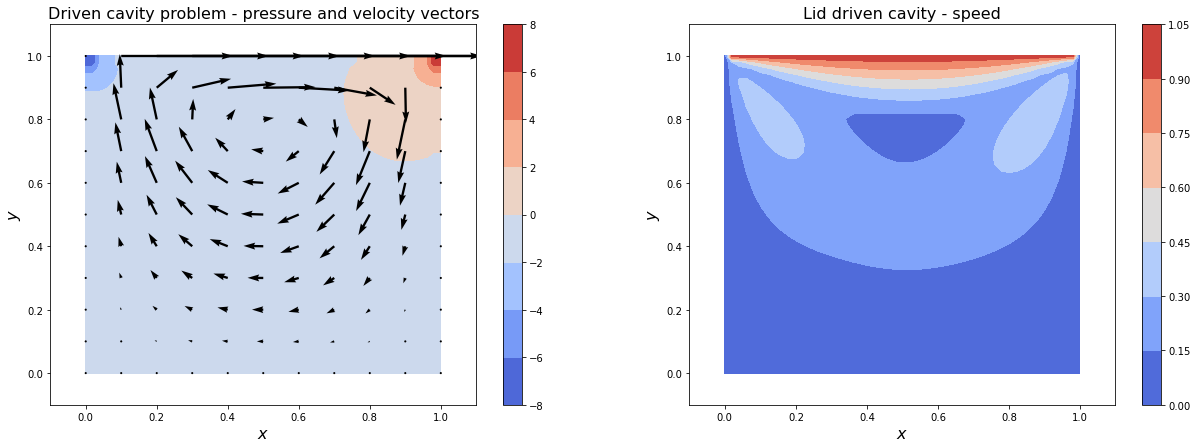

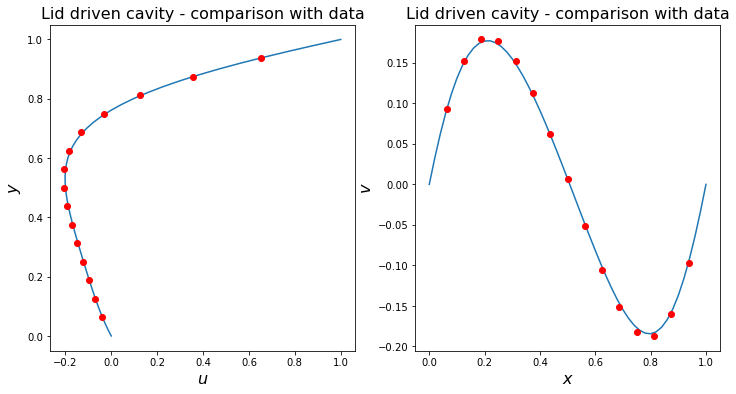

In [17]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,p, cmap=cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Driven cavity problem - pressure and velocity vectors', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Lid driven cavity - speed', fontsize=16)


fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.plot(u[int(np.shape(u)[0]/2),:],Y[int(np.shape(u)[0]/2),:])
ax1.plot(Marchi_Re10_u[:,1],Marchi_Re10_u[:,0],'ro')
ax1.set_xlabel('$u$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Lid driven cavity - comparison with data', fontsize=16)
ax1 = fig.add_subplot(122)
ax1.plot(X[:,int(np.shape(u)[0]/2)],v[:,int(np.shape(u)[0]/2)])
ax1.plot(Marchi_Re10_v[:,0],Marchi_Re10_v[:,1],'ro')
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$v$', fontsize=16)
ax1.set_title('Lid driven cavity - comparison with data', fontsize=16)

In [8]:
# physical parameters (Re=100)
rho = 1
nu = 1./100.

# define spatial mesh
# Size of rectangular domain
Lx = 1
Ly = Lx

# Number of grid points in each direction, including boundary nodes
Nx = 51
Ny = Nx

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# time stepping parameters
dt = 1.e-3
t_end = 20.0

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1]=1  # set velocity on cavity lid equal to 1
u[:, 0]=0
u[0, :]=0
u[-1, :]=0
v[:, -1]=0
v[:, 0]=0
v[0, :]=0
v[-1, :]=0

import time
start = time.time()
u, v, p = solve_NS(u, v, p, rho, nu, dt, t_end, dx, dy, rtol=1.e-6, logs = True)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 0.00100000
pressure solve iterations = 6287
norm(u) = 7.00200115, norm(v) = 0.01717228
Courant number: 0.05000000

Time = 0.00200000
pressure solve iterations = 10415
norm(u) = 7.00745138, norm(v) = 0.04178818
Courant number: 0.05000000

Time = 0.00300000
pressure solve iterations = 3377
norm(u) = 7.01571186, norm(v) = 0.07040053
Courant number: 0.05000000

Time = 0.00400000
pressure solve iterations = 2237
norm(u) = 7.02629300, norm(v) = 0.10129464
Courant number: 0.05000000

Time = 0.00500000
pressure solve iterations = 1611
norm(u) = 7.03879842, norm(v) = 0.13348772
Courant number: 0.05000000

Time = 0.00600000
pressure solve iterations = 1277
norm(u) = 7.05289950, norm(v) = 0.16636950
Courant number: 0.05000000

Time = 0.00700000
pressure solve iterations = 1693
norm(u) = 7.06832007, norm(v) = 0.19955296
Courant number: 0.05000000

Time = 0.00800000
pressure solve iterations = 13658
norm(u) = 7.08482681, norm(v) = 0.23281611
Courant number: 0.05000000

Time = 0.00900000
pre

pressure solve iterations = 1202
norm(u) = 8.09213298, norm(v) = 1.45629452
Courant number: 0.05000000

Time = 0.06900000
pressure solve iterations = 1159
norm(u) = 8.10454567, norm(v) = 1.46874023
Courant number: 0.05000000

Time = 0.07000000
pressure solve iterations = 1115
norm(u) = 8.11684240, norm(v) = 1.48105031
Courant number: 0.05000000

Time = 0.07100000
pressure solve iterations = 1073
norm(u) = 8.12902510, norm(v) = 1.49322771
Courant number: 0.05000000

Time = 0.07200000
pressure solve iterations = 1034
norm(u) = 8.14109566, norm(v) = 1.50527537
Courant number: 0.05000000

Time = 0.07300000
pressure solve iterations =  996
norm(u) = 8.15305591, norm(v) = 1.51719615
Courant number: 0.05000000

Time = 0.07400000
pressure solve iterations =  957
norm(u) = 8.16490767, norm(v) = 1.52899282
Courant number: 0.05000000

Time = 0.07500000
pressure solve iterations =  921
norm(u) = 8.17665271, norm(v) = 1.54066800
Courant number: 0.05000000

Time = 0.07600000
pressure solve iteration

pressure solve iterations =   42
norm(u) = 8.97606154, norm(v) = 2.32948626
Courant number: 0.05000000

Time = 0.17100000
pressure solve iterations =   41
norm(u) = 8.98228134, norm(v) = 2.33578881
Courant number: 0.05000000

Time = 0.17200000
pressure solve iterations =   40
norm(u) = 8.98847020, norm(v) = 2.34206513
Courant number: 0.05000000

Time = 0.17300000
pressure solve iterations =   39
norm(u) = 8.99462840, norm(v) = 2.34831554
Courant number: 0.05000000

Time = 0.17400000
pressure solve iterations =   39
norm(u) = 9.00075625, norm(v) = 2.35454011
Courant number: 0.05000000

Time = 0.17500000
pressure solve iterations =   38
norm(u) = 9.00685403, norm(v) = 2.36073917
Courant number: 0.05000000

Time = 0.17600000
pressure solve iterations =   38
norm(u) = 9.01292204, norm(v) = 2.36691280
Courant number: 0.05000000

Time = 0.17700000
pressure solve iterations =   36
norm(u) = 9.01896049, norm(v) = 2.37306164
Courant number: 0.05000000

Time = 0.17800000
pressure solve iteration

norm(u) = 9.48377661, norm(v) = 2.86457065
Courant number: 0.05000000

Time = 0.27200000
pressure solve iterations =   14
norm(u) = 9.48786044, norm(v) = 2.86907668
Courant number: 0.05000000

Time = 0.27300000
pressure solve iterations =   13
norm(u) = 9.49192983, norm(v) = 2.87357072
Courant number: 0.05000000

Time = 0.27400000
pressure solve iterations =   14
norm(u) = 9.49598492, norm(v) = 2.87805256
Courant number: 0.05000000

Time = 0.27500000
pressure solve iterations =   13
norm(u) = 9.50002576, norm(v) = 2.88252249
Courant number: 0.05000000

Time = 0.27600000
pressure solve iterations =   13
norm(u) = 9.50405245, norm(v) = 2.88698056
Courant number: 0.05000000

Time = 0.27700000
pressure solve iterations =   14
norm(u) = 9.50806512, norm(v) = 2.89142657
Courant number: 0.05000000

Time = 0.27800000
pressure solve iterations =   12
norm(u) = 9.51206377, norm(v) = 2.89586105
Courant number: 0.05000000

Time = 0.27900000
pressure solve iterations =   14
norm(u) = 9.51604857, no

norm(u) = 9.80228796, norm(v) = 3.22861750
Courant number: 0.05000000

Time = 0.36200000
pressure solve iterations =    8
norm(u) = 9.80535375, norm(v) = 3.23225900
Courant number: 0.05000000

Time = 0.36300000
pressure solve iterations =    8
norm(u) = 9.80841070, norm(v) = 3.23589295
Courant number: 0.05000000

Time = 0.36400000
pressure solve iterations =    9
norm(u) = 9.81145887, norm(v) = 3.23951921
Courant number: 0.05000000

Time = 0.36500000
pressure solve iterations =    8
norm(u) = 9.81449828, norm(v) = 3.24313795
Courant number: 0.05000000

Time = 0.36600000
pressure solve iterations =    8
norm(u) = 9.81752899, norm(v) = 3.24674920
Courant number: 0.05000000

Time = 0.36700000
pressure solve iterations =    8
norm(u) = 9.82055102, norm(v) = 3.25035299
Courant number: 0.05000000

Time = 0.36800000
pressure solve iterations =    8
norm(u) = 9.82356442, norm(v) = 3.25394937
Courant number: 0.05000000

Time = 0.36900000
pressure solve iterations =    9
norm(u) = 9.82656924, no

Courant number: 0.05000000

Time = 0.43200000
pressure solve iterations =    6
norm(u) = 10.00014975, norm(v) = 3.46999026
Courant number: 0.05000000

Time = 0.43300000
pressure solve iterations =    7
norm(u) = 10.00267803, norm(v) = 3.47316408
Courant number: 0.05000000

Time = 0.43400000
pressure solve iterations =    6
norm(u) = 10.00519986, norm(v) = 3.47633223
Courant number: 0.05000000

Time = 0.43500000
pressure solve iterations =    6
norm(u) = 10.00771526, norm(v) = 3.47949474
Courant number: 0.05000000

Time = 0.43600000
pressure solve iterations =    7
norm(u) = 10.01022425, norm(v) = 3.48265156
Courant number: 0.05000000

Time = 0.43700000
pressure solve iterations =    6
norm(u) = 10.01272687, norm(v) = 3.48580276
Courant number: 0.05000000

Time = 0.43800000
pressure solve iterations =    6
norm(u) = 10.01522314, norm(v) = 3.48894837
Courant number: 0.05000000

Time = 0.43900000
pressure solve iterations =    7
norm(u) = 10.01771307, norm(v) = 3.49208835
Courant number: 

pressure solve iterations =    5
norm(u) = 10.28074941, norm(v) = 3.83863543
Courant number: 0.05000000

Time = 0.56200000
pressure solve iterations =    4
norm(u) = 10.28261807, norm(v) = 3.84121393
Courant number: 0.05000000

Time = 0.56300000
pressure solve iterations =    5
norm(u) = 10.28448269, norm(v) = 3.84378871
Courant number: 0.05000000

Time = 0.56400000
pressure solve iterations =    4
norm(u) = 10.28634331, norm(v) = 3.84635973
Courant number: 0.05000000

Time = 0.56500000
pressure solve iterations =    5
norm(u) = 10.28819990, norm(v) = 3.84892705
Courant number: 0.05000000

Time = 0.56600000
pressure solve iterations =    5
norm(u) = 10.29005248, norm(v) = 3.85149068
Courant number: 0.05000000

Time = 0.56700000
pressure solve iterations =    4
norm(u) = 10.29190111, norm(v) = 3.85405056
Courant number: 0.05000000

Time = 0.56800000
pressure solve iterations =    4
norm(u) = 10.29374579, norm(v) = 3.85660672
Courant number: 0.05000000

Time = 0.56900000
pressure solve i

Courant number: 0.05000000

Time = 0.63900000
pressure solve iterations =    4
norm(u) = 10.41531669, norm(v) = 4.02925649
Courant number: 0.05000000

Time = 0.64000000
pressure solve iterations =    3
norm(u) = 10.41690621, norm(v) = 4.03157134
Courant number: 0.05000000

Time = 0.64100000
pressure solve iterations =    5
norm(u) = 10.41849249, norm(v) = 4.03388329
Courant number: 0.05000000

Time = 0.64200000
pressure solve iterations =    3
norm(u) = 10.42007568, norm(v) = 4.03619208
Courant number: 0.05000000

Time = 0.64300000
pressure solve iterations =    5
norm(u) = 10.42165566, norm(v) = 4.03849798
Courant number: 0.05000000

Time = 0.64400000
pressure solve iterations =    3
norm(u) = 10.42323255, norm(v) = 4.04080073
Courant number: 0.05000000

Time = 0.64500000
pressure solve iterations =    4
norm(u) = 10.42480632, norm(v) = 4.04310049
Courant number: 0.05000000

Time = 0.64600000
pressure solve iterations =    4
norm(u) = 10.42637695, norm(v) = 4.04539725
Courant number: 

norm(u) = 10.52494801, norm(v) = 4.19279045
Courant number: 0.05000000

Time = 0.71400000
pressure solve iterations =    4
norm(u) = 10.52632594, norm(v) = 4.19489863
Courant number: 0.05000000

Time = 0.71500000
pressure solve iterations =    3
norm(u) = 10.52770134, norm(v) = 4.19700416
Courant number: 0.05000000

Time = 0.71600000
pressure solve iterations =    3
norm(u) = 10.52907422, norm(v) = 4.19910704
Courant number: 0.05000000

Time = 0.71700000
pressure solve iterations =    4
norm(u) = 10.53044449, norm(v) = 4.20120747
Courant number: 0.05000000

Time = 0.71800000
pressure solve iterations =    3
norm(u) = 10.53181225, norm(v) = 4.20330528
Courant number: 0.05000000

Time = 0.71900000
pressure solve iterations =    4
norm(u) = 10.53317742, norm(v) = 4.20540066
Courant number: 0.05000000

Time = 0.72000000
pressure solve iterations =    4
norm(u) = 10.53454000, norm(v) = 4.20749360
Courant number: 0.05000000

Time = 0.72100000
pressure solve iterations =    3
norm(u) = 10.535

Courant number: 0.05000000

Time = 0.78200000
pressure solve iterations =    3
norm(u) = 10.61433938, norm(v) = 4.33251676
Courant number: 0.05000000

Time = 0.78300000
pressure solve iterations =    3
norm(u) = 10.61555503, norm(v) = 4.33446021
Courant number: 0.05000000

Time = 0.78400000
pressure solve iterations =    4
norm(u) = 10.61676845, norm(v) = 4.33640164
Courant number: 0.05000000

Time = 0.78500000
pressure solve iterations =    3
norm(u) = 10.61797975, norm(v) = 4.33834082
Courant number: 0.05000000

Time = 0.78600000
pressure solve iterations =    3
norm(u) = 10.61918893, norm(v) = 4.34027774
Courant number: 0.05000000

Time = 0.78700000
pressure solve iterations =    3
norm(u) = 10.62039601, norm(v) = 4.34221241
Courant number: 0.05000000

Time = 0.78800000
pressure solve iterations =    3
norm(u) = 10.62160097, norm(v) = 4.34414485
Courant number: 0.05000000

Time = 0.78900000
pressure solve iterations =    3
norm(u) = 10.62280383, norm(v) = 4.34607507
Courant number: 

norm(u) = 10.71678037, norm(v) = 4.50081000
Courant number: 0.05000000

Time = 0.87400000
pressure solve iterations =    2
norm(u) = 10.71782081, norm(v) = 4.50256832
Courant number: 0.05000000

Time = 0.87500000
pressure solve iterations =    3
norm(u) = 10.71885950, norm(v) = 4.50432483
Courant number: 0.05000000

Time = 0.87600000
pressure solve iterations =    3
norm(u) = 10.71989645, norm(v) = 4.50607951
Courant number: 0.05000000

Time = 0.87700000
pressure solve iterations =    3
norm(u) = 10.72093168, norm(v) = 4.50783238
Courant number: 0.05000000

Time = 0.87800000
pressure solve iterations =    3
norm(u) = 10.72196517, norm(v) = 4.50958344
Courant number: 0.05000000

Time = 0.87900000
pressure solve iterations =    3
norm(u) = 10.72299694, norm(v) = 4.51133268
Courant number: 0.05000000

Time = 0.88000000
pressure solve iterations =    2
norm(u) = 10.72402711, norm(v) = 4.51307984
Courant number: 0.05000000

Time = 0.88100000
pressure solve iterations =    4
norm(u) = 10.725

pressure solve iterations =    3
norm(u) = 10.82082661, norm(v) = 4.68215595
Courant number: 0.05000000

Time = 0.98300000
pressure solve iterations =    2
norm(u) = 10.82170062, norm(v) = 4.68372887
Courant number: 0.05000000

Time = 0.98400000
pressure solve iterations =    3
norm(u) = 10.82257321, norm(v) = 4.68530038
Courant number: 0.05000000

Time = 0.98500000
pressure solve iterations =    2
norm(u) = 10.82344455, norm(v) = 4.68687016
Courant number: 0.05000000

Time = 0.98600000
pressure solve iterations =    3
norm(u) = 10.82431447, norm(v) = 4.68843852
Courant number: 0.05000000

Time = 0.98700000
pressure solve iterations =    2
norm(u) = 10.82518314, norm(v) = 4.69000517
Courant number: 0.05000000

Time = 0.98800000
pressure solve iterations =    3
norm(u) = 10.82605041, norm(v) = 4.69157041
Courant number: 0.05000000

Time = 0.98900000
pressure solve iterations =    2
norm(u) = 10.82691642, norm(v) = 4.69313394
Courant number: 0.05000000

Time = 0.99000000
pressure solve i

Courant number: 0.05000000

Time = 1.07600000
pressure solve iterations =    3
norm(u) = 10.89745423, norm(v) = 4.82354033
Courant number: 0.05000000

Time = 1.07700000
pressure solve iterations =    3
norm(u) = 10.89821306, norm(v) = 4.82497753
Courant number: 0.05000000

Time = 1.07800000
pressure solve iterations =    2
norm(u) = 10.89897084, norm(v) = 4.82641325
Courant number: 0.05000000

Time = 1.07900000
pressure solve iterations =    2
norm(u) = 10.89972758, norm(v) = 4.82784749
Courant number: 0.05000000

Time = 1.08000000
pressure solve iterations =    2
norm(u) = 10.90048327, norm(v) = 4.82928025
Courant number: 0.05000000

Time = 1.08100000
pressure solve iterations =    3
norm(u) = 10.90123775, norm(v) = 4.83071192
Courant number: 0.05000000

Time = 1.08200000
pressure solve iterations =    2
norm(u) = 10.90199119, norm(v) = 4.83214211
Courant number: 0.05000000

Time = 1.08300000
pressure solve iterations =    3
norm(u) = 10.90274343, norm(v) = 4.83357120
Courant number: 

norm(u) = 10.97279822, norm(v) = 4.97001927
Courant number: 0.05000000

Time = 1.18400000
pressure solve iterations =    2
norm(u) = 10.97345043, norm(v) = 4.97132213
Courant number: 0.05000000

Time = 1.18500000
pressure solve iterations =    3
norm(u) = 10.97410160, norm(v) = 4.97262414
Courant number: 0.05000000

Time = 1.18600000
pressure solve iterations =    2
norm(u) = 10.97475190, norm(v) = 4.97392491
Courant number: 0.05000000

Time = 1.18700000
pressure solve iterations =    1
norm(u) = 10.97540153, norm(v) = 4.97522407
Courant number: 0.05000000

Time = 1.18800000
pressure solve iterations =    3
norm(u) = 10.97605011, norm(v) = 4.97652241
Courant number: 0.05000000

Time = 1.18900000
pressure solve iterations =    3
norm(u) = 10.97669765, norm(v) = 4.97781991
Courant number: 0.05000000

Time = 1.19000000
pressure solve iterations =    1
norm(u) = 10.97734452, norm(v) = 4.97911580
Courant number: 0.05000000

Time = 1.19100000
pressure solve iterations =    3
norm(u) = 10.977

norm(u) = 11.02635681, norm(v) = 5.07918828
Courant number: 0.05000000

Time = 1.27100000
pressure solve iterations =    1
norm(u) = 11.02693717, norm(v) = 5.08039527
Courant number: 0.05000000

Time = 1.27200000
pressure solve iterations =    3
norm(u) = 11.02751660, norm(v) = 5.08160162
Courant number: 0.05000000

Time = 1.27300000
pressure solve iterations =    2
norm(u) = 11.02809528, norm(v) = 5.08280691
Courant number: 0.05000000

Time = 1.27400000
pressure solve iterations =    2
norm(u) = 11.02867322, norm(v) = 5.08401113
Courant number: 0.05000000

Time = 1.27500000
pressure solve iterations =    2
norm(u) = 11.02925041, norm(v) = 5.08521429
Courant number: 0.05000000

Time = 1.27600000
pressure solve iterations =    2
norm(u) = 11.02982685, norm(v) = 5.08641639
Courant number: 0.05000000

Time = 1.27700000
pressure solve iterations =    2
norm(u) = 11.03040256, norm(v) = 5.08761743
Courant number: 0.05000000

Time = 1.27800000
pressure solve iterations =    2
norm(u) = 11.030

Courant number: 0.05000000

Time = 1.34600000
pressure solve iterations =    1
norm(u) = 11.06838144, norm(v) = 5.16806809
Courant number: 0.05000000

Time = 1.34700000
pressure solve iterations =    3
norm(u) = 11.06890758, norm(v) = 5.16920006
Courant number: 0.05000000

Time = 1.34800000
pressure solve iterations =    2
norm(u) = 11.06943305, norm(v) = 5.17033109
Courant number: 0.05000000

Time = 1.34900000
pressure solve iterations =    1
norm(u) = 11.06995805, norm(v) = 5.17146077
Courant number: 0.05000000

Time = 1.35000000
pressure solve iterations =    3
norm(u) = 11.07048219, norm(v) = 5.17258994
Courant number: 0.05000000

Time = 1.35100000
pressure solve iterations =    1
norm(u) = 11.07100585, norm(v) = 5.17371776
Courant number: 0.05000000

Time = 1.35200000
pressure solve iterations =    3
norm(u) = 11.07152866, norm(v) = 5.17484507
Courant number: 0.05000000

Time = 1.35300000
pressure solve iterations =    1
norm(u) = 11.07205100, norm(v) = 5.17597104
Courant number: 

norm(u) = 11.12161208, norm(v) = 5.28504437
Courant number: 0.05000000

Time = 1.45500000
pressure solve iterations =    2
norm(u) = 11.12207302, norm(v) = 5.28607994
Courant number: 0.05000000

Time = 1.45600000
pressure solve iterations =    2
norm(u) = 11.12253339, norm(v) = 5.28711474
Courant number: 0.05000000

Time = 1.45700000
pressure solve iterations =    2
norm(u) = 11.12299318, norm(v) = 5.28814875
Courant number: 0.05000000

Time = 1.45800000
pressure solve iterations =    1
norm(u) = 11.12345260, norm(v) = 5.28918155
Courant number: 0.05000000

Time = 1.45900000
pressure solve iterations =    2
norm(u) = 11.12391144, norm(v) = 5.29021359
Courant number: 0.05000000

Time = 1.46000000
pressure solve iterations =    2
norm(u) = 11.12436971, norm(v) = 5.29124486
Courant number: 0.05000000

Time = 1.46100000
pressure solve iterations =    2
norm(u) = 11.12482739, norm(v) = 5.29227536
Courant number: 0.05000000

Time = 1.46200000
pressure solve iterations =    2
norm(u) = 11.125

pressure solve iterations =    2
norm(u) = 11.17565568, norm(v) = 5.40920757
Courant number: 0.05000000

Time = 1.58100000
pressure solve iterations =    2
norm(u) = 11.17605415, norm(v) = 5.41014452
Courant number: 0.05000000

Time = 1.58200000
pressure solve iterations =    1
norm(u) = 11.17645234, norm(v) = 5.41108038
Courant number: 0.05000000

Time = 1.58300000
pressure solve iterations =    2
norm(u) = 11.17685003, norm(v) = 5.41201562
Courant number: 0.05000000

Time = 1.58400000
pressure solve iterations =    2
norm(u) = 11.17724723, norm(v) = 5.41295026
Courant number: 0.05000000

Time = 1.58500000
pressure solve iterations =    2
norm(u) = 11.17764392, norm(v) = 5.41388428
Courant number: 0.05000000

Time = 1.58600000
pressure solve iterations =    1
norm(u) = 11.17804034, norm(v) = 5.41481722
Courant number: 0.05000000

Time = 1.58700000
pressure solve iterations =    2
norm(u) = 11.17843625, norm(v) = 5.41574956
Courant number: 0.05000000

Time = 1.58800000
pressure solve i

norm(u) = 11.22224030, norm(v) = 5.52085886
Courant number: 0.05000000

Time = 1.70600000
pressure solve iterations =    2
norm(u) = 11.22258821, norm(v) = 5.52170996
Courant number: 0.05000000

Time = 1.70700000
pressure solve iterations =    1
norm(u) = 11.22293590, norm(v) = 5.52256009
Courant number: 0.05000000

Time = 1.70800000
pressure solve iterations =    1
norm(u) = 11.22328338, norm(v) = 5.52340927
Courant number: 0.05000000

Time = 1.70900000
pressure solve iterations =    3
norm(u) = 11.22363018, norm(v) = 5.52425844
Courant number: 0.05000000

Time = 1.71000000
pressure solve iterations =    1
norm(u) = 11.22397677, norm(v) = 5.52510666
Courant number: 0.05000000

Time = 1.71100000
pressure solve iterations =    1
norm(u) = 11.22432314, norm(v) = 5.52595393
Courant number: 0.05000000

Time = 1.71200000
pressure solve iterations =    3
norm(u) = 11.22466885, norm(v) = 5.52680120
Courant number: 0.05000000

Time = 1.71300000
pressure solve iterations =    1
norm(u) = 11.225

norm(u) = 11.26123690, norm(v) = 5.61774477
Courant number: 0.05000000

Time = 1.82500000
pressure solve iterations =    2
norm(u) = 11.26154500, norm(v) = 5.61852330
Courant number: 0.05000000

Time = 1.82600000
pressure solve iterations =    1
norm(u) = 11.26185295, norm(v) = 5.61930097
Courant number: 0.05000000

Time = 1.82700000
pressure solve iterations =    2
norm(u) = 11.26216048, norm(v) = 5.62007826
Courant number: 0.05000000

Time = 1.82800000
pressure solve iterations =    1
norm(u) = 11.26246786, norm(v) = 5.62085469
Courant number: 0.05000000

Time = 1.82900000
pressure solve iterations =    2
norm(u) = 11.26277483, norm(v) = 5.62163076
Courant number: 0.05000000

Time = 1.83000000
pressure solve iterations =    1
norm(u) = 11.26308164, norm(v) = 5.62240596
Courant number: 0.05000000

Time = 1.83100000
pressure solve iterations =    2
norm(u) = 11.26338804, norm(v) = 5.62318080
Courant number: 0.05000000

Time = 1.83200000
pressure solve iterations =    2
norm(u) = 11.263

norm(u) = 11.28808428, norm(v) = 5.68628343
Courant number: 0.05000000

Time = 1.91600000
pressure solve iterations =    1
norm(u) = 11.28836640, norm(v) = 5.68701163
Courant number: 0.05000000

Time = 1.91700000
pressure solve iterations =    1
norm(u) = 11.28864839, norm(v) = 5.68773902
Courant number: 0.05000000

Time = 1.91800000
pressure solve iterations =    2
norm(u) = 11.28892999, norm(v) = 5.68846612
Courant number: 0.05000000

Time = 1.91900000
pressure solve iterations =    2
norm(u) = 11.28921122, norm(v) = 5.68919292
Courant number: 0.05000000

Time = 1.92000000
pressure solve iterations =    1
norm(u) = 11.28949231, norm(v) = 5.68991893
Courant number: 0.05000000

Time = 1.92100000
pressure solve iterations =    2
norm(u) = 11.28977303, norm(v) = 5.69064463
Courant number: 0.05000000

Time = 1.92200000
pressure solve iterations =    1
norm(u) = 11.29005361, norm(v) = 5.69136954
Courant number: 0.05000000

Time = 1.92300000
pressure solve iterations =    2
norm(u) = 11.290

norm(u) = 11.33416139, norm(v) = 5.80736779
Courant number: 0.05000000

Time = 2.09300000
pressure solve iterations =    2
norm(u) = 11.33440134, norm(v) = 5.80800963
Courant number: 0.05000000

Time = 2.09400000
pressure solve iterations =    2
norm(u) = 11.33464094, norm(v) = 5.80865129
Courant number: 0.05000000

Time = 2.09500000
pressure solve iterations =    1
norm(u) = 11.33488045, norm(v) = 5.80929227
Courant number: 0.05000000

Time = 2.09600000
pressure solve iterations =    1
norm(u) = 11.33511986, norm(v) = 5.80993256
Courant number: 0.05000000

Time = 2.09700000
pressure solve iterations =    2
norm(u) = 11.33535893, norm(v) = 5.81057267
Courant number: 0.05000000

Time = 2.09800000
pressure solve iterations =    1
norm(u) = 11.33559791, norm(v) = 5.81121209
Courant number: 0.05000000

Time = 2.09900000
pressure solve iterations =    2
norm(u) = 11.33583654, norm(v) = 5.81185134
Courant number: 0.05000000

Time = 2.10000000
pressure solve iterations =    1
norm(u) = 11.336

Courant number: 0.05000000

Time = 2.20200000
pressure solve iterations =    1
norm(u) = 11.35934939, norm(v) = 5.87534804
Courant number: 0.05000000

Time = 2.20300000
pressure solve iterations =    2
norm(u) = 11.35956768, norm(v) = 5.87594258
Courant number: 0.05000000

Time = 2.20400000
pressure solve iterations =    1
norm(u) = 11.35978590, norm(v) = 5.87653649
Courant number: 0.05000000

Time = 2.20500000
pressure solve iterations =    2
norm(u) = 11.36000379, norm(v) = 5.87713029
Courant number: 0.05000000

Time = 2.20600000
pressure solve iterations =    1
norm(u) = 11.36022160, norm(v) = 5.87772345
Courant number: 0.05000000

Time = 2.20700000
pressure solve iterations =    2
norm(u) = 11.36043909, norm(v) = 5.87831651
Courant number: 0.05000000

Time = 2.20800000
pressure solve iterations =    1
norm(u) = 11.36065650, norm(v) = 5.87890894
Courant number: 0.05000000

Time = 2.20900000
pressure solve iterations =    2
norm(u) = 11.36087358, norm(v) = 5.87950126
Courant number: 

pressure solve iterations =    2
norm(u) = 11.37543386, norm(v) = 5.91938585
Courant number: 0.05000000

Time = 2.27900000
pressure solve iterations =    2
norm(u) = 11.37563869, norm(v) = 5.91995049
Courant number: 0.05000000

Time = 2.28000000
pressure solve iterations =    1
norm(u) = 11.37584346, norm(v) = 5.92051453
Courant number: 0.05000000

Time = 2.28100000
pressure solve iterations =    1
norm(u) = 11.37604816, norm(v) = 5.92107798
Courant number: 0.05000000

Time = 2.28200000
pressure solve iterations =    1
norm(u) = 11.37625281, norm(v) = 5.92164084
Courant number: 0.05000000

Time = 2.28300000
pressure solve iterations =    2
norm(u) = 11.37645713, norm(v) = 5.92220363
Courant number: 0.05000000

Time = 2.28400000
pressure solve iterations =    1
norm(u) = 11.37666138, norm(v) = 5.92276583
Courant number: 0.05000000

Time = 2.28500000
pressure solve iterations =    2
norm(u) = 11.37686532, norm(v) = 5.92332795
Courant number: 0.05000000

Time = 2.28600000
pressure solve i

Courant number: 0.05000000

Time = 2.34700000
pressure solve iterations =    2
norm(u) = 11.38919720, norm(v) = 5.95743566
Courant number: 0.05000000

Time = 2.34800000
pressure solve iterations =    1
norm(u) = 11.38939121, norm(v) = 5.95797396
Courant number: 0.05000000

Time = 2.34900000
pressure solve iterations =    2
norm(u) = 11.38958490, norm(v) = 5.95851223
Courant number: 0.05000000

Time = 2.35000000
pressure solve iterations =    1
norm(u) = 11.38977854, norm(v) = 5.95904993
Courant number: 0.05000000

Time = 2.35100000
pressure solve iterations =    2
norm(u) = 11.38997186, norm(v) = 5.95958759
Courant number: 0.05000000

Time = 2.35200000
pressure solve iterations =    1
norm(u) = 11.39016513, norm(v) = 5.96012469
Courant number: 0.05000000

Time = 2.35300000
pressure solve iterations =    1
norm(u) = 11.39035835, norm(v) = 5.96066123
Courant number: 0.05000000

Time = 2.35400000
pressure solve iterations =    1
norm(u) = 11.39055151, norm(v) = 5.96119721
Courant number: 

pressure solve iterations =    1
norm(u) = 11.40928738, norm(v) = 6.01354595
Courant number: 0.05000000

Time = 2.45600000
pressure solve iterations =    2
norm(u) = 11.40946560, norm(v) = 6.01404689
Courant number: 0.05000000

Time = 2.45700000
pressure solve iterations =    1
norm(u) = 11.40964377, norm(v) = 6.01454731
Courant number: 0.05000000

Time = 2.45800000
pressure solve iterations =    1
norm(u) = 11.40982191, norm(v) = 6.01504722
Courant number: 0.05000000

Time = 2.45900000
pressure solve iterations =    2
norm(u) = 11.40999973, norm(v) = 6.01554713
Courant number: 0.05000000

Time = 2.46000000
pressure solve iterations =    1
norm(u) = 11.41017751, norm(v) = 6.01604653
Courant number: 0.05000000

Time = 2.46100000
pressure solve iterations =    2
norm(u) = 11.41035499, norm(v) = 6.01654593
Courant number: 0.05000000

Time = 2.46200000
pressure solve iterations =    1
norm(u) = 11.41053242, norm(v) = 6.01704482
Courant number: 0.05000000

Time = 2.46300000
pressure solve i


Time = 2.57100000
pressure solve iterations =    2
norm(u) = 11.42909621, norm(v) = 6.06948034
Courant number: 0.05000000

Time = 2.57200000
pressure solve iterations =    1
norm(u) = 11.42925958, norm(v) = 6.06994427
Courant number: 0.05000000

Time = 2.57300000
pressure solve iterations =    1
norm(u) = 11.42942292, norm(v) = 6.07040772
Courant number: 0.05000000

Time = 2.57400000
pressure solve iterations =    1
norm(u) = 11.42958623, norm(v) = 6.07087070
Courant number: 0.05000000

Time = 2.57500000
pressure solve iterations =    2
norm(u) = 11.42974923, norm(v) = 6.07133373
Courant number: 0.05000000

Time = 2.57600000
pressure solve iterations =    1
norm(u) = 11.42991220, norm(v) = 6.07179629
Courant number: 0.05000000

Time = 2.57700000
pressure solve iterations =    1
norm(u) = 11.43007514, norm(v) = 6.07225838
Courant number: 0.05000000

Time = 2.57800000
pressure solve iterations =    2
norm(u) = 11.43023777, norm(v) = 6.07272051
Courant number: 0.05000000

Time = 2.579000

pressure solve iterations =    1
norm(u) = 11.44592622, norm(v) = 6.11742496
Courant number: 0.05000000

Time = 2.67900000
pressure solve iterations =    2
norm(u) = 11.44607746, norm(v) = 6.11785747
Courant number: 0.05000000

Time = 2.68000000
pressure solve iterations =    1
norm(u) = 11.44622868, norm(v) = 6.11828953
Courant number: 0.05000000

Time = 2.68100000
pressure solve iterations =    2
norm(u) = 11.44637960, norm(v) = 6.11872169
Courant number: 0.05000000

Time = 2.68200000
pressure solve iterations =    1
norm(u) = 11.44653050, norm(v) = 6.11915340
Courant number: 0.05000000

Time = 2.68300000
pressure solve iterations =    1
norm(u) = 11.44668137, norm(v) = 6.11958469
Courant number: 0.05000000

Time = 2.68400000
pressure solve iterations =    1
norm(u) = 11.44683221, norm(v) = 6.12001553
Courant number: 0.05000000

Time = 2.68500000
pressure solve iterations =    2
norm(u) = 11.44698275, norm(v) = 6.12044647
Courant number: 0.05000000

Time = 2.68600000
pressure solve i

norm(u) = 11.46235981, norm(v) = 6.16456884
Courant number: 0.05000000

Time = 2.79200000
pressure solve iterations =    1
norm(u) = 11.46249966, norm(v) = 6.16497065
Courant number: 0.05000000

Time = 2.79300000
pressure solve iterations =    2
norm(u) = 11.46263922, norm(v) = 6.16537257
Courant number: 0.05000000

Time = 2.79400000
pressure solve iterations =    1
norm(u) = 11.46277876, norm(v) = 6.16577409
Courant number: 0.05000000

Time = 2.79500000
pressure solve iterations =    1
norm(u) = 11.46291828, norm(v) = 6.16617521
Courant number: 0.05000000

Time = 2.79600000
pressure solve iterations =    2
norm(u) = 11.46305750, norm(v) = 6.16657645
Courant number: 0.05000000

Time = 2.79700000
pressure solve iterations =    1
norm(u) = 11.46319671, norm(v) = 6.16697728
Courant number: 0.05000000

Time = 2.79800000
pressure solve iterations =    1
norm(u) = 11.46333589, norm(v) = 6.16737772
Courant number: 0.05000000

Time = 2.79900000
pressure solve iterations =    1
norm(u) = 11.463

pressure solve iterations =    1
norm(u) = 11.47455835, norm(v) = 6.19974216
Courant number: 0.05000000

Time = 2.88200000
pressure solve iterations =    1
norm(u) = 11.47468991, norm(v) = 6.20012139
Courant number: 0.05000000

Time = 2.88300000
pressure solve iterations =    2
norm(u) = 11.47482117, norm(v) = 6.20050076
Courant number: 0.05000000

Time = 2.88400000
pressure solve iterations =    1
norm(u) = 11.47495242, norm(v) = 6.20087975
Courant number: 0.05000000

Time = 2.88500000
pressure solve iterations =    2
norm(u) = 11.47508338, norm(v) = 6.20125889
Courant number: 0.05000000

Time = 2.88600000
pressure solve iterations =    1
norm(u) = 11.47521432, norm(v) = 6.20163765
Courant number: 0.05000000

Time = 2.88700000
pressure solve iterations =    1
norm(u) = 11.47534525, norm(v) = 6.20201603
Courant number: 0.05000000

Time = 2.88800000
pressure solve iterations =    1
norm(u) = 11.47547615, norm(v) = 6.20239404
Courant number: 0.05000000

Time = 2.88900000
pressure solve i

norm(u) = 11.48897973, norm(v) = 6.24150189
Courant number: 0.05000000

Time = 2.99600000
pressure solve iterations =    1
norm(u) = 11.48910137, norm(v) = 6.24185526
Courant number: 0.05000000

Time = 2.99700000
pressure solve iterations =    1
norm(u) = 11.48922299, norm(v) = 6.24220829
Courant number: 0.05000000

Time = 2.99800000
pressure solve iterations =    2
norm(u) = 11.48934434, norm(v) = 6.24256146
Courant number: 0.05000000

Time = 2.99900000
pressure solve iterations =    1
norm(u) = 11.48946567, norm(v) = 6.24291428
Courant number: 0.05000000

Time = 3.00000000
pressure solve iterations =    1
norm(u) = 11.48958700, norm(v) = 6.24326675
Courant number: 0.05000000

Time = 3.00100000
pressure solve iterations =    2
norm(u) = 11.48970805, norm(v) = 6.24361937
Courant number: 0.05000000

Time = 3.00200000
pressure solve iterations =    1
norm(u) = 11.48982910, norm(v) = 6.24397164
Courant number: 0.05000000

Time = 3.00300000
pressure solve iterations =    1
norm(u) = 11.489

pressure solve iterations =    2
norm(u) = 11.50233523, norm(v) = 6.28043646
Courant number: 0.05000000

Time = 3.11000000
pressure solve iterations =    1
norm(u) = 11.50244833, norm(v) = 6.28076525
Courant number: 0.05000000

Time = 3.11100000
pressure solve iterations =    1
norm(u) = 11.50256142, norm(v) = 6.28109372
Courant number: 0.05000000

Time = 3.11200000
pressure solve iterations =    2
norm(u) = 11.50267433, norm(v) = 6.28142217
Courant number: 0.05000000

Time = 3.11300000
pressure solve iterations =    1
norm(u) = 11.50278723, norm(v) = 6.28175030
Courant number: 0.05000000

Time = 3.11400000
pressure solve iterations =    1
norm(u) = 11.50290011, norm(v) = 6.28207810
Courant number: 0.05000000

Time = 3.11500000
pressure solve iterations =    2
norm(u) = 11.50301282, norm(v) = 6.28240590
Courant number: 0.05000000

Time = 3.11600000
pressure solve iterations =    1
norm(u) = 11.50312552, norm(v) = 6.28273338
Courant number: 0.05000000

Time = 3.11700000
pressure solve i

pressure solve iterations =    1
norm(u) = 11.51455556, norm(v) = 6.31601406
Courant number: 0.05000000

Time = 3.22200000
pressure solve iterations =    2
norm(u) = 11.51466073, norm(v) = 6.31632086
Courant number: 0.05000000

Time = 3.22300000
pressure solve iterations =    1
norm(u) = 11.51476590, norm(v) = 6.31662735
Courant number: 0.05000000

Time = 3.22400000
pressure solve iterations =    2
norm(u) = 11.51487090, norm(v) = 6.31693386
Courant number: 0.05000000

Time = 3.22500000
pressure solve iterations =    1
norm(u) = 11.51497589, norm(v) = 6.31724006
Courant number: 0.05000000

Time = 3.22600000
pressure solve iterations =    1
norm(u) = 11.51508088, norm(v) = 6.31754597
Courant number: 0.05000000

Time = 3.22700000
pressure solve iterations =    2
norm(u) = 11.51518570, norm(v) = 6.31785188
Courant number: 0.05000000

Time = 3.22800000
pressure solve iterations =    1
norm(u) = 11.51529052, norm(v) = 6.31815749
Courant number: 0.05000000

Time = 3.22900000
pressure solve i

pressure solve iterations =    1
norm(u) = 11.52437022, norm(v) = 6.34460380
Courant number: 0.05000000

Time = 3.31800000
pressure solve iterations =    1
norm(u) = 11.52446919, norm(v) = 6.34489309
Courant number: 0.05000000

Time = 3.31900000
pressure solve iterations =    2
norm(u) = 11.52456798, norm(v) = 6.34518243
Courant number: 0.05000000

Time = 3.32000000
pressure solve iterations =    1
norm(u) = 11.52466676, norm(v) = 6.34547149
Courant number: 0.05000000

Time = 3.32100000
pressure solve iterations =    2
norm(u) = 11.52476537, norm(v) = 6.34576060
Courant number: 0.05000000

Time = 3.32200000
pressure solve iterations =    1
norm(u) = 11.52486396, norm(v) = 6.34604943
Courant number: 0.05000000

Time = 3.32300000
pressure solve iterations =    1
norm(u) = 11.52496256, norm(v) = 6.34633797
Courant number: 0.05000000

Time = 3.32400000
pressure solve iterations =    2
norm(u) = 11.52506097, norm(v) = 6.34662656
Courant number: 0.05000000

Time = 3.32500000
pressure solve i

norm(u) = 11.53480625, norm(v) = 6.37510362
Courant number: 0.05000000

Time = 3.42700000
pressure solve iterations =    2
norm(u) = 11.53489899, norm(v) = 6.37537358
Courant number: 0.05000000

Time = 3.42800000
pressure solve iterations =    1
norm(u) = 11.53499172, norm(v) = 6.37564329
Courant number: 0.05000000

Time = 3.42900000
pressure solve iterations =    1
norm(u) = 11.53508443, norm(v) = 6.37591273
Courant number: 0.05000000

Time = 3.43000000
pressure solve iterations =    2
norm(u) = 11.53517701, norm(v) = 6.37618217
Courant number: 0.05000000

Time = 3.43100000
pressure solve iterations =    1
norm(u) = 11.53526957, norm(v) = 6.37645136
Courant number: 0.05000000

Time = 3.43200000
pressure solve iterations =    2
norm(u) = 11.53536199, norm(v) = 6.37672055
Courant number: 0.05000000

Time = 3.43300000
pressure solve iterations =    1
norm(u) = 11.53545439, norm(v) = 6.37698948
Courant number: 0.05000000

Time = 3.43400000
pressure solve iterations =    1
norm(u) = 11.535

pressure solve iterations =    1
norm(u) = 11.54439321, norm(v) = 6.40309642
Courant number: 0.05000000

Time = 3.53400000
pressure solve iterations =    1
norm(u) = 11.54447987, norm(v) = 6.40334949
Courant number: 0.05000000

Time = 3.53500000
pressure solve iterations =    2
norm(u) = 11.54456641, norm(v) = 6.40360255
Courant number: 0.05000000

Time = 3.53600000
pressure solve iterations =    1
norm(u) = 11.54465294, norm(v) = 6.40385536
Courant number: 0.05000000

Time = 3.53700000
pressure solve iterations =    1
norm(u) = 11.54473946, norm(v) = 6.40410793
Courant number: 0.05000000

Time = 3.53800000
pressure solve iterations =    2
norm(u) = 11.54482586, norm(v) = 6.40436050
Courant number: 0.05000000

Time = 3.53900000
pressure solve iterations =    1
norm(u) = 11.54491226, norm(v) = 6.40461282
Courant number: 0.05000000

Time = 3.54000000
pressure solve iterations =    2
norm(u) = 11.54499853, norm(v) = 6.40486514
Courant number: 0.05000000

Time = 3.54100000
pressure solve i

pressure solve iterations =    1
norm(u) = 11.55410599, norm(v) = 6.43145486
Courant number: 0.05000000

Time = 3.65000000
pressure solve iterations =    1
norm(u) = 11.55418689, norm(v) = 6.43169052
Courant number: 0.05000000

Time = 3.65100000
pressure solve iterations =    2
norm(u) = 11.55426767, norm(v) = 6.43192616
Courant number: 0.05000000

Time = 3.65200000
pressure solve iterations =    1
norm(u) = 11.55434845, norm(v) = 6.43216158
Courant number: 0.05000000

Time = 3.65300000
pressure solve iterations =    2
norm(u) = 11.55442910, norm(v) = 6.43239699
Courant number: 0.05000000

Time = 3.65400000
pressure solve iterations =    1
norm(u) = 11.55450976, norm(v) = 6.43263217
Courant number: 0.05000000

Time = 3.65500000
pressure solve iterations =    1
norm(u) = 11.55459041, norm(v) = 6.43286712
Courant number: 0.05000000

Time = 3.65600000
pressure solve iterations =    1
norm(u) = 11.55467105, norm(v) = 6.43310184
Courant number: 0.05000000

Time = 3.65700000
pressure solve i

Courant number: 0.05000000

Time = 3.77600000
pressure solve iterations =    2
norm(u) = 11.56399044, norm(v) = 6.46027414
Courant number: 0.05000000

Time = 3.77700000
pressure solve iterations =    1
norm(u) = 11.56406523, norm(v) = 6.46049250
Courant number: 0.05000000

Time = 3.77800000
pressure solve iterations =    2
norm(u) = 11.56413990, norm(v) = 6.46071087
Courant number: 0.05000000

Time = 3.77900000
pressure solve iterations =    1
norm(u) = 11.56421456, norm(v) = 6.46092902
Courant number: 0.05000000

Time = 3.78000000
pressure solve iterations =    1
norm(u) = 11.56428923, norm(v) = 6.46114696
Courant number: 0.05000000

Time = 3.78100000
pressure solve iterations =    1
norm(u) = 11.56436388, norm(v) = 6.46136470
Courant number: 0.05000000

Time = 3.78200000
pressure solve iterations =    2
norm(u) = 11.56443842, norm(v) = 6.46158244
Courant number: 0.05000000

Time = 3.78300000
pressure solve iterations =    1
norm(u) = 11.56451295, norm(v) = 6.46179997
Courant number: 

pressure solve iterations =    1
norm(u) = 11.57355640, norm(v) = 6.48817946
Courant number: 0.05000000

Time = 3.91000000
pressure solve iterations =    2
norm(u) = 11.57362557, norm(v) = 6.48838080
Courant number: 0.05000000

Time = 3.91100000
pressure solve iterations =    1
norm(u) = 11.57369475, norm(v) = 6.48858195
Courant number: 0.05000000

Time = 3.91200000
pressure solve iterations =    1
norm(u) = 11.57376391, norm(v) = 6.48878291
Courant number: 0.05000000

Time = 3.91300000
pressure solve iterations =    2
norm(u) = 11.57383298, norm(v) = 6.48898385
Courant number: 0.05000000

Time = 3.91400000
pressure solve iterations =    1
norm(u) = 11.57390205, norm(v) = 6.48918460
Courant number: 0.05000000

Time = 3.91500000
pressure solve iterations =    2
norm(u) = 11.57397102, norm(v) = 6.48938535
Courant number: 0.05000000

Time = 3.91600000
pressure solve iterations =    1
norm(u) = 11.57403998, norm(v) = 6.48958590
Courant number: 0.05000000

Time = 3.91700000
pressure solve i

norm(u) = 11.58227732, norm(v) = 6.51354311
Courant number: 0.05000000

Time = 4.04100000
pressure solve iterations =    2
norm(u) = 11.58234121, norm(v) = 6.51372933
Courant number: 0.05000000

Time = 4.04200000
pressure solve iterations =    1
norm(u) = 11.58240510, norm(v) = 6.51391536
Courant number: 0.05000000

Time = 4.04300000
pressure solve iterations =    2
norm(u) = 11.58246889, norm(v) = 6.51410139
Courant number: 0.05000000

Time = 4.04400000
pressure solve iterations =    1
norm(u) = 11.58253268, norm(v) = 6.51428725
Courant number: 0.05000000

Time = 4.04500000
pressure solve iterations =    1
norm(u) = 11.58259647, norm(v) = 6.51447293
Courant number: 0.05000000

Time = 4.04600000
pressure solve iterations =    2
norm(u) = 11.58266016, norm(v) = 6.51465861
Courant number: 0.05000000

Time = 4.04700000
pressure solve iterations =    1
norm(u) = 11.58272385, norm(v) = 6.51484410
Courant number: 0.05000000

Time = 4.04800000
pressure solve iterations =    2
norm(u) = 11.582

norm(u) = 11.58914999, norm(v) = 6.53353122
Courant number: 0.05000000

Time = 4.15200000
pressure solve iterations =    1
norm(u) = 11.58920995, norm(v) = 6.53370510
Courant number: 0.05000000

Time = 4.15300000
pressure solve iterations =    2
norm(u) = 11.58926982, norm(v) = 6.53387898
Courant number: 0.05000000

Time = 4.15400000
pressure solve iterations =    1
norm(u) = 11.58932969, norm(v) = 6.53405269
Courant number: 0.05000000

Time = 4.15500000
pressure solve iterations =    2
norm(u) = 11.58938947, norm(v) = 6.53422639
Courant number: 0.05000000

Time = 4.15600000
pressure solve iterations =    1
norm(u) = 11.58944924, norm(v) = 6.53439993
Courant number: 0.05000000

Time = 4.15700000
pressure solve iterations =    1
norm(u) = 11.58950901, norm(v) = 6.53457330
Courant number: 0.05000000

Time = 4.15800000
pressure solve iterations =    2
norm(u) = 11.58956870, norm(v) = 6.53474667
Courant number: 0.05000000

Time = 4.15900000
pressure solve iterations =    1
norm(u) = 11.589

norm(u) = 11.59440530, norm(v) = 6.54877282
Courant number: 0.05000000

Time = 4.24200000
pressure solve iterations =    1
norm(u) = 11.59446221, norm(v) = 6.54893749
Courant number: 0.05000000

Time = 4.24300000
pressure solve iterations =    2
norm(u) = 11.59451903, norm(v) = 6.54910218
Courant number: 0.05000000

Time = 4.24400000
pressure solve iterations =    1
norm(u) = 11.59457585, norm(v) = 6.54926670
Courant number: 0.05000000

Time = 4.24500000
pressure solve iterations =    2
norm(u) = 11.59463258, norm(v) = 6.54943124
Courant number: 0.05000000

Time = 4.24600000
pressure solve iterations =    1
norm(u) = 11.59468931, norm(v) = 6.54959562
Courant number: 0.05000000

Time = 4.24700000
pressure solve iterations =    1
norm(u) = 11.59474603, norm(v) = 6.54975984
Courant number: 0.05000000

Time = 4.24800000
pressure solve iterations =    2
norm(u) = 11.59480267, norm(v) = 6.54992407
Courant number: 0.05000000

Time = 4.24900000
pressure solve iterations =    1
norm(u) = 11.594


Time = 4.36300000
pressure solve iterations =    2
norm(u) = 11.60109646, norm(v) = 6.56817773
Courant number: 0.05000000

Time = 4.36400000
pressure solve iterations =    1
norm(u) = 11.60114939, norm(v) = 6.56833092
Courant number: 0.05000000

Time = 4.36500000
pressure solve iterations =    2
norm(u) = 11.60120224, norm(v) = 6.56848410
Courant number: 0.05000000

Time = 4.36600000
pressure solve iterations =    1
norm(u) = 11.60125509, norm(v) = 6.56863713
Courant number: 0.05000000

Time = 4.36700000
pressure solve iterations =    1
norm(u) = 11.60130794, norm(v) = 6.56879001
Courant number: 0.05000000

Time = 4.36800000
pressure solve iterations =    2
norm(u) = 11.60136071, norm(v) = 6.56894289
Courant number: 0.05000000

Time = 4.36900000
pressure solve iterations =    1
norm(u) = 11.60141348, norm(v) = 6.56909562
Courant number: 0.05000000

Time = 4.37000000
pressure solve iterations =    2
norm(u) = 11.60146618, norm(v) = 6.56924835
Courant number: 0.05000000

Time = 4.371000


Time = 4.49200000
pressure solve iterations =    2
norm(u) = 11.60767339, norm(v) = 6.58719821
Courant number: 0.05000000

Time = 4.49300000
pressure solve iterations =    1
norm(u) = 11.60772244, norm(v) = 6.58733999
Courant number: 0.05000000

Time = 4.49400000
pressure solve iterations =    2
norm(u) = 11.60777143, norm(v) = 6.58748178
Courant number: 0.05000000

Time = 4.49500000
pressure solve iterations =    1
norm(u) = 11.60782041, norm(v) = 6.58762342
Courant number: 0.05000000

Time = 4.49600000
pressure solve iterations =    1
norm(u) = 11.60786938, norm(v) = 6.58776493
Courant number: 0.05000000

Time = 4.49700000
pressure solve iterations =    2
norm(u) = 11.60791829, norm(v) = 6.58790644
Courant number: 0.05000000

Time = 4.49800000
pressure solve iterations =    1
norm(u) = 11.60796719, norm(v) = 6.58804781
Courant number: 0.05000000

Time = 4.49900000
pressure solve iterations =    2
norm(u) = 11.60801603, norm(v) = 6.58818919
Courant number: 0.05000000

Time = 4.500000

pressure solve iterations =    2
norm(u) = 11.61408775, norm(v) = 6.60572798
Courant number: 0.05000000

Time = 4.62900000
pressure solve iterations =    1
norm(u) = 11.61413308, norm(v) = 6.60585870
Courant number: 0.05000000

Time = 4.63000000
pressure solve iterations =    2
norm(u) = 11.61417836, norm(v) = 6.60598942
Courant number: 0.05000000

Time = 4.63100000
pressure solve iterations =    1
norm(u) = 11.61422362, norm(v) = 6.60612001
Courant number: 0.05000000

Time = 4.63200000
pressure solve iterations =    1
norm(u) = 11.61426889, norm(v) = 6.60625047
Courant number: 0.05000000

Time = 4.63300000
pressure solve iterations =    2
norm(u) = 11.61431410, norm(v) = 6.60638093
Courant number: 0.05000000

Time = 4.63400000
pressure solve iterations =    1
norm(u) = 11.61435930, norm(v) = 6.60651127
Courant number: 0.05000000

Time = 4.63500000
pressure solve iterations =    1
norm(u) = 11.61440450, norm(v) = 6.60664147
Courant number: 0.05000000

Time = 4.63600000
pressure solve i

norm(u) = 11.61993298, norm(v) = 6.62256294
Courant number: 0.05000000

Time = 4.76300000
pressure solve iterations =    2
norm(u) = 11.61997484, norm(v) = 6.62268366
Courant number: 0.05000000

Time = 4.76400000
pressure solve iterations =    1
norm(u) = 11.62001670, norm(v) = 6.62280426
Courant number: 0.05000000

Time = 4.76500000
pressure solve iterations =    1
norm(u) = 11.62005855, norm(v) = 6.62292475
Courant number: 0.05000000

Time = 4.76600000
pressure solve iterations =    2
norm(u) = 11.62010035, norm(v) = 6.62304524
Courant number: 0.05000000

Time = 4.76700000
pressure solve iterations =    1
norm(u) = 11.62014214, norm(v) = 6.62316561
Courant number: 0.05000000

Time = 4.76800000
pressure solve iterations =    2
norm(u) = 11.62018387, norm(v) = 6.62328599
Courant number: 0.05000000

Time = 4.76900000
pressure solve iterations =    1
norm(u) = 11.62022560, norm(v) = 6.62340625
Courant number: 0.05000000

Time = 4.77000000
pressure solve iterations =    1
norm(u) = 11.620

norm(u) = 11.62518057, norm(v) = 6.63765869
Courant number: 0.05000000

Time = 4.89300000
pressure solve iterations =    1
norm(u) = 11.62521943, norm(v) = 6.63777029
Courant number: 0.05000000

Time = 4.89400000
pressure solve iterations =    2
norm(u) = 11.62525824, norm(v) = 6.63788189
Courant number: 0.05000000

Time = 4.89500000
pressure solve iterations =    1
norm(u) = 11.62529705, norm(v) = 6.63799338
Courant number: 0.05000000

Time = 4.89600000
pressure solve iterations =    2
norm(u) = 11.62533580, norm(v) = 6.63810488
Courant number: 0.05000000

Time = 4.89700000
pressure solve iterations =    1
norm(u) = 11.62537455, norm(v) = 6.63821626
Courant number: 0.05000000

Time = 4.89800000
pressure solve iterations =    1
norm(u) = 11.62541330, norm(v) = 6.63832754
Courant number: 0.05000000

Time = 4.89900000
pressure solve iterations =    1
norm(u) = 11.62545204, norm(v) = 6.63843871
Courant number: 0.05000000

Time = 4.90000000
pressure solve iterations =    2
norm(u) = 11.625

Courant number: 0.05000000

Time = 5.03000000
pressure solve iterations =    1
norm(u) = 11.63033468, norm(v) = 6.65244987
Courant number: 0.05000000

Time = 5.03100000
pressure solve iterations =    2
norm(u) = 11.63037051, norm(v) = 6.65255271
Courant number: 0.05000000

Time = 5.03200000
pressure solve iterations =    1
norm(u) = 11.63040634, norm(v) = 6.65265546
Courant number: 0.05000000

Time = 5.03300000
pressure solve iterations =    2
norm(u) = 11.63044212, norm(v) = 6.65275821
Courant number: 0.05000000

Time = 5.03400000
pressure solve iterations =    1
norm(u) = 11.63047790, norm(v) = 6.65286085
Courant number: 0.05000000

Time = 5.03500000
pressure solve iterations =    1
norm(u) = 11.63051367, norm(v) = 6.65296340
Courant number: 0.05000000

Time = 5.03600000
pressure solve iterations =    2
norm(u) = 11.63054939, norm(v) = 6.65306595
Courant number: 0.05000000

Time = 5.03700000
pressure solve iterations =    1
norm(u) = 11.63058511, norm(v) = 6.65316840
Courant number: 

norm(u) = 11.63455669, norm(v) = 6.66455168
Courant number: 0.05000000

Time = 5.15300000
pressure solve iterations =    1
norm(u) = 11.63459011, norm(v) = 6.66464720
Courant number: 0.05000000

Time = 5.15400000
pressure solve iterations =    1
norm(u) = 11.63462352, norm(v) = 6.66474263
Courant number: 0.05000000

Time = 5.15500000
pressure solve iterations =    2
norm(u) = 11.63465688, norm(v) = 6.66483806
Courant number: 0.05000000

Time = 5.15600000
pressure solve iterations =    1
norm(u) = 11.63469025, norm(v) = 6.66493339
Courant number: 0.05000000

Time = 5.15700000
pressure solve iterations =    2
norm(u) = 11.63472356, norm(v) = 6.66502873
Courant number: 0.05000000

Time = 5.15800000
pressure solve iterations =    1
norm(u) = 11.63475688, norm(v) = 6.66512398
Courant number: 0.05000000

Time = 5.15900000
pressure solve iterations =    1
norm(u) = 11.63479019, norm(v) = 6.66521913
Courant number: 0.05000000

Time = 5.16000000
pressure solve iterations =    2
norm(u) = 11.634

pressure solve iterations =    2
norm(u) = 11.63870786, norm(v) = 6.67642100
Courant number: 0.05000000

Time = 5.28200000
pressure solve iterations =    1
norm(u) = 11.63873885, norm(v) = 6.67650948
Courant number: 0.05000000

Time = 5.28300000
pressure solve iterations =    2
norm(u) = 11.63876979, norm(v) = 6.67659796
Courant number: 0.05000000

Time = 5.28400000
pressure solve iterations =    1
norm(u) = 11.63880073, norm(v) = 6.67668636
Courant number: 0.05000000

Time = 5.28500000
pressure solve iterations =    1
norm(u) = 11.63883166, norm(v) = 6.67677467
Courant number: 0.05000000

Time = 5.28600000
pressure solve iterations =    1
norm(u) = 11.63886260, norm(v) = 6.67686290
Courant number: 0.05000000

Time = 5.28700000
pressure solve iterations =    2
norm(u) = 11.63889349, norm(v) = 6.67695112
Courant number: 0.05000000

Time = 5.28800000
pressure solve iterations =    1
norm(u) = 11.63892437, norm(v) = 6.67703926
Courant number: 0.05000000

Time = 5.28900000
pressure solve i

norm(u) = 11.64247151, norm(v) = 6.68716677
Courant number: 0.05000000

Time = 5.40800000
pressure solve iterations =    2
norm(u) = 11.64250027, norm(v) = 6.68724889
Courant number: 0.05000000

Time = 5.40900000
pressure solve iterations =    1
norm(u) = 11.64252903, norm(v) = 6.68733093
Courant number: 0.05000000

Time = 5.41000000
pressure solve iterations =    1
norm(u) = 11.64255779, norm(v) = 6.68741289
Courant number: 0.05000000

Time = 5.41100000
pressure solve iterations =    2
norm(u) = 11.64258651, norm(v) = 6.68749485
Courant number: 0.05000000

Time = 5.41200000
pressure solve iterations =    1
norm(u) = 11.64261523, norm(v) = 6.68757674
Courant number: 0.05000000

Time = 5.41300000
pressure solve iterations =    2
norm(u) = 11.64264391, norm(v) = 6.68765862
Courant number: 0.05000000

Time = 5.41400000
pressure solve iterations =    1
norm(u) = 11.64267258, norm(v) = 6.68774042
Courant number: 0.05000000

Time = 5.41500000
pressure solve iterations =    1
norm(u) = 11.642

pressure solve iterations =    1
norm(u) = 11.64559180, norm(v) = 6.69606446
Courant number: 0.05000000

Time = 5.52000000
pressure solve iterations =    1
norm(u) = 11.64561876, norm(v) = 6.69614123
Courant number: 0.05000000

Time = 5.52100000
pressure solve iterations =    2
norm(u) = 11.64564569, norm(v) = 6.69621801
Courant number: 0.05000000

Time = 5.52200000
pressure solve iterations =    1
norm(u) = 11.64567261, norm(v) = 6.69629471
Courant number: 0.05000000

Time = 5.52300000
pressure solve iterations =    1
norm(u) = 11.64569953, norm(v) = 6.69637134
Courant number: 0.05000000

Time = 5.52400000
pressure solve iterations =    2
norm(u) = 11.64572641, norm(v) = 6.69644796
Courant number: 0.05000000

Time = 5.52500000
pressure solve iterations =    1
norm(u) = 11.64575329, norm(v) = 6.69652451
Courant number: 0.05000000

Time = 5.52600000
pressure solve iterations =    2
norm(u) = 11.64578014, norm(v) = 6.69660106
Courant number: 0.05000000

Time = 5.52700000
pressure solve i

pressure solve iterations =    1
norm(u) = 11.64904320, norm(v) = 6.70588427
Courant number: 0.05000000

Time = 5.65300000
pressure solve iterations =    1
norm(u) = 11.64906816, norm(v) = 6.70595518
Courant number: 0.05000000

Time = 5.65400000
pressure solve iterations =    2
norm(u) = 11.64909308, norm(v) = 6.70602608
Courant number: 0.05000000

Time = 5.65500000
pressure solve iterations =    1
norm(u) = 11.64911799, norm(v) = 6.70609692
Courant number: 0.05000000

Time = 5.65600000
pressure solve iterations =    2
norm(u) = 11.64914288, norm(v) = 6.70616776
Courant number: 0.05000000

Time = 5.65700000
pressure solve iterations =    1
norm(u) = 11.64916776, norm(v) = 6.70623853
Courant number: 0.05000000

Time = 5.65800000
pressure solve iterations =    1
norm(u) = 11.64919263, norm(v) = 6.70630923
Courant number: 0.05000000

Time = 5.65900000
pressure solve iterations =    2
norm(u) = 11.64921748, norm(v) = 6.70637993
Courant number: 0.05000000

Time = 5.66000000
pressure solve i

norm(u) = 11.65106419, norm(v) = 6.71163091
Courant number: 0.05000000

Time = 5.73600000
pressure solve iterations =    2
norm(u) = 11.65108794, norm(v) = 6.71169846
Courant number: 0.05000000

Time = 5.73700000
pressure solve iterations =    1
norm(u) = 11.65111168, norm(v) = 6.71176595
Courant number: 0.05000000

Time = 5.73800000
pressure solve iterations =    1
norm(u) = 11.65113542, norm(v) = 6.71183337
Courant number: 0.05000000

Time = 5.73900000
pressure solve iterations =    2
norm(u) = 11.65115912, norm(v) = 6.71190078
Courant number: 0.05000000

Time = 5.74000000
pressure solve iterations =    1
norm(u) = 11.65118283, norm(v) = 6.71196814
Courant number: 0.05000000

Time = 5.74100000
pressure solve iterations =    1
norm(u) = 11.65120653, norm(v) = 6.71203542
Courant number: 0.05000000

Time = 5.74200000
pressure solve iterations =    2
norm(u) = 11.65123020, norm(v) = 6.71210271
Courant number: 0.05000000

Time = 5.74300000
pressure solve iterations =    1
norm(u) = 11.651

norm(u) = 11.65319307, norm(v) = 6.71767628
Courant number: 0.05000000

Time = 5.82800000
pressure solve iterations =    1
norm(u) = 11.65321559, norm(v) = 6.71774017
Courant number: 0.05000000

Time = 5.82900000
pressure solve iterations =    2
norm(u) = 11.65323809, norm(v) = 6.71780405
Courant number: 0.05000000

Time = 5.83000000
pressure solve iterations =    1
norm(u) = 11.65326058, norm(v) = 6.71786787
Courant number: 0.05000000

Time = 5.83100000
pressure solve iterations =    1
norm(u) = 11.65328307, norm(v) = 6.71793162
Courant number: 0.05000000

Time = 5.83200000
pressure solve iterations =    2
norm(u) = 11.65330552, norm(v) = 6.71799538
Courant number: 0.05000000

Time = 5.83300000
pressure solve iterations =    1
norm(u) = 11.65332798, norm(v) = 6.71805907
Courant number: 0.05000000

Time = 5.83400000
pressure solve iterations =    2
norm(u) = 11.65335041, norm(v) = 6.71812277
Courant number: 0.05000000

Time = 5.83500000
pressure solve iterations =    1
norm(u) = 11.653

pressure solve iterations =    1
norm(u) = 11.65561385, norm(v) = 6.72454157
Courant number: 0.05000000

Time = 5.93900000
pressure solve iterations =    2
norm(u) = 11.65563495, norm(v) = 6.72460139
Courant number: 0.05000000

Time = 5.94000000
pressure solve iterations =    1
norm(u) = 11.65565605, norm(v) = 6.72466114
Courant number: 0.05000000

Time = 5.94100000
pressure solve iterations =    2
norm(u) = 11.65567712, norm(v) = 6.72472090
Courant number: 0.05000000

Time = 5.94200000
pressure solve iterations =    1
norm(u) = 11.65569818, norm(v) = 6.72478060
Courant number: 0.05000000

Time = 5.94300000
pressure solve iterations =    1
norm(u) = 11.65571924, norm(v) = 6.72484024
Courant number: 0.05000000

Time = 5.94400000
pressure solve iterations =    2
norm(u) = 11.65574028, norm(v) = 6.72489988
Courant number: 0.05000000

Time = 5.94500000
pressure solve iterations =    1
norm(u) = 11.65576131, norm(v) = 6.72495946
Courant number: 0.05000000

Time = 5.94600000
pressure solve i

norm(u) = 11.65821677, norm(v) = 6.73191430
Courant number: 0.05000000

Time = 6.06700000
pressure solve iterations =    1
norm(u) = 11.65823635, norm(v) = 6.73196971
Courant number: 0.05000000

Time = 6.06800000
pressure solve iterations =    1
norm(u) = 11.65825593, norm(v) = 6.73202507
Courant number: 0.05000000

Time = 6.06900000
pressure solve iterations =    2
norm(u) = 11.65827548, norm(v) = 6.73208043
Courant number: 0.05000000

Time = 6.07000000
pressure solve iterations =    1
norm(u) = 11.65829503, norm(v) = 6.73213573
Courant number: 0.05000000

Time = 6.07100000
pressure solve iterations =    2
norm(u) = 11.65831456, norm(v) = 6.73219104
Courant number: 0.05000000

Time = 6.07200000
pressure solve iterations =    1
norm(u) = 11.65833408, norm(v) = 6.73224629
Courant number: 0.05000000

Time = 6.07300000
pressure solve iterations =    1
norm(u) = 11.65835360, norm(v) = 6.73230148
Courant number: 0.05000000

Time = 6.07400000
pressure solve iterations =    2
norm(u) = 11.658

norm(u) = 11.66021053, norm(v) = 6.73755719
Courant number: 0.05000000

Time = 6.17200000
pressure solve iterations =    1
norm(u) = 11.66022894, norm(v) = 6.73760924
Courant number: 0.05000000

Time = 6.17300000
pressure solve iterations =    2
norm(u) = 11.66024732, norm(v) = 6.73766129
Courant number: 0.05000000

Time = 6.17400000
pressure solve iterations =    1
norm(u) = 11.66026570, norm(v) = 6.73771329
Courant number: 0.05000000

Time = 6.17500000
pressure solve iterations =    1
norm(u) = 11.66028408, norm(v) = 6.73776524
Courant number: 0.05000000

Time = 6.17600000
pressure solve iterations =    2
norm(u) = 11.66030243, norm(v) = 6.73781719
Courant number: 0.05000000

Time = 6.17700000
pressure solve iterations =    1
norm(u) = 11.66032079, norm(v) = 6.73786908
Courant number: 0.05000000

Time = 6.17800000
pressure solve iterations =    2
norm(u) = 11.66033912, norm(v) = 6.73792098
Courant number: 0.05000000

Time = 6.17900000
pressure solve iterations =    1
norm(u) = 11.660

norm(u) = 11.66251586, norm(v) = 6.74406853
Courant number: 0.05000000

Time = 6.30200000
pressure solve iterations =    1
norm(u) = 11.66253291, norm(v) = 6.74411671
Courant number: 0.05000000

Time = 6.30300000
pressure solve iterations =    1
norm(u) = 11.66254995, norm(v) = 6.74416484
Courant number: 0.05000000

Time = 6.30400000
pressure solve iterations =    2
norm(u) = 11.66256697, norm(v) = 6.74421298
Courant number: 0.05000000

Time = 6.30500000
pressure solve iterations =    1
norm(u) = 11.66258399, norm(v) = 6.74426107
Courant number: 0.05000000

Time = 6.30600000
pressure solve iterations =    2
norm(u) = 11.66260099, norm(v) = 6.74430916
Courant number: 0.05000000

Time = 6.30700000
pressure solve iterations =    1
norm(u) = 11.66261798, norm(v) = 6.74435720
Courant number: 0.05000000

Time = 6.30800000
pressure solve iterations =    1
norm(u) = 11.66263498, norm(v) = 6.74440519
Courant number: 0.05000000

Time = 6.30900000
pressure solve iterations =    2
norm(u) = 11.662

norm(u) = 11.66485566, norm(v) = 6.75067403
Courant number: 0.05000000

Time = 6.44500000
pressure solve iterations =    2
norm(u) = 11.66487134, norm(v) = 6.75071826
Courant number: 0.05000000

Time = 6.44600000
pressure solve iterations =    1
norm(u) = 11.66488702, norm(v) = 6.75076246
Courant number: 0.05000000

Time = 6.44700000
pressure solve iterations =    2
norm(u) = 11.66490268, norm(v) = 6.75080665
Courant number: 0.05000000

Time = 6.44800000
pressure solve iterations =    1
norm(u) = 11.66491833, norm(v) = 6.75085080
Courant number: 0.05000000

Time = 6.44900000
pressure solve iterations =    1
norm(u) = 11.66493398, norm(v) = 6.75089491
Courant number: 0.05000000

Time = 6.45000000
pressure solve iterations =    1
norm(u) = 11.66494963, norm(v) = 6.75093897
Courant number: 0.05000000

Time = 6.45100000
pressure solve iterations =    2
norm(u) = 11.66496526, norm(v) = 6.75098303
Courant number: 0.05000000

Time = 6.45200000
pressure solve iterations =    1
norm(u) = 11.664

Courant number: 0.05000000

Time = 6.59000000
pressure solve iterations =    1
norm(u) = 11.66705039, norm(v) = 6.75685954
Courant number: 0.05000000

Time = 6.59100000
pressure solve iterations =    2
norm(u) = 11.66706476, norm(v) = 6.75690012
Courant number: 0.05000000

Time = 6.59200000
pressure solve iterations =    1
norm(u) = 11.66707914, norm(v) = 6.75694065
Courant number: 0.05000000

Time = 6.59300000
pressure solve iterations =    1
norm(u) = 11.66709351, norm(v) = 6.75698115
Courant number: 0.05000000

Time = 6.59400000
pressure solve iterations =    2
norm(u) = 11.66710786, norm(v) = 6.75702165
Courant number: 0.05000000

Time = 6.59500000
pressure solve iterations =    1
norm(u) = 11.66712221, norm(v) = 6.75706210
Courant number: 0.05000000

Time = 6.59600000
pressure solve iterations =    2
norm(u) = 11.66713654, norm(v) = 6.75710256
Courant number: 0.05000000

Time = 6.59700000
pressure solve iterations =    1
norm(u) = 11.66715087, norm(v) = 6.75714298
Courant number: 


Time = 6.70400000
pressure solve iterations =    1
norm(u) = 11.66863762, norm(v) = 6.76132897
Courant number: 0.05000000

Time = 6.70500000
pressure solve iterations =    2
norm(u) = 11.66865109, norm(v) = 6.76136685
Courant number: 0.05000000

Time = 6.70600000
pressure solve iterations =    1
norm(u) = 11.66866454, norm(v) = 6.76140469
Courant number: 0.05000000

Time = 6.70700000
pressure solve iterations =    1
norm(u) = 11.66867800, norm(v) = 6.76144248
Courant number: 0.05000000

Time = 6.70800000
pressure solve iterations =    2
norm(u) = 11.66869144, norm(v) = 6.76148029
Courant number: 0.05000000

Time = 6.70900000
pressure solve iterations =    1
norm(u) = 11.66870488, norm(v) = 6.76151805
Courant number: 0.05000000

Time = 6.71000000
pressure solve iterations =    1
norm(u) = 11.66871831, norm(v) = 6.76155577
Courant number: 0.05000000

Time = 6.71100000
pressure solve iterations =    2
norm(u) = 11.66873173, norm(v) = 6.76159350
Courant number: 0.05000000

Time = 6.712000

pressure solve iterations =    2
norm(u) = 11.66991974, norm(v) = 6.76493497
Courant number: 0.05000000

Time = 6.80300000
pressure solve iterations =    1
norm(u) = 11.66993244, norm(v) = 6.76497070
Courant number: 0.05000000

Time = 6.80400000
pressure solve iterations =    1
norm(u) = 11.66994514, norm(v) = 6.76500639
Courant number: 0.05000000

Time = 6.80500000
pressure solve iterations =    2
norm(u) = 11.66995782, norm(v) = 6.76504209
Courant number: 0.05000000

Time = 6.80600000
pressure solve iterations =    1
norm(u) = 11.66997050, norm(v) = 6.76507775
Courant number: 0.05000000

Time = 6.80700000
pressure solve iterations =    2
norm(u) = 11.66998316, norm(v) = 6.76511341
Courant number: 0.05000000

Time = 6.80800000
pressure solve iterations =    1
norm(u) = 11.66999582, norm(v) = 6.76514904
Courant number: 0.05000000

Time = 6.80900000
pressure solve iterations =    1
norm(u) = 11.67000848, norm(v) = 6.76518462
Courant number: 0.05000000

Time = 6.81000000
pressure solve i

norm(u) = 11.67135591, norm(v) = 6.76897377
Courant number: 0.05000000

Time = 6.92000000
pressure solve iterations =    1
norm(u) = 11.67136777, norm(v) = 6.76900706
Courant number: 0.05000000

Time = 6.92100000
pressure solve iterations =    2
norm(u) = 11.67137962, norm(v) = 6.76904035
Courant number: 0.05000000

Time = 6.92200000
pressure solve iterations =    1
norm(u) = 11.67139147, norm(v) = 6.76907360
Courant number: 0.05000000

Time = 6.92300000
pressure solve iterations =    2
norm(u) = 11.67140331, norm(v) = 6.76910686
Courant number: 0.05000000

Time = 6.92400000
pressure solve iterations =    1
norm(u) = 11.67141514, norm(v) = 6.76914008
Courant number: 0.05000000

Time = 6.92500000
pressure solve iterations =    1
norm(u) = 11.67142697, norm(v) = 6.76917327
Courant number: 0.05000000

Time = 6.92600000
pressure solve iterations =    2
norm(u) = 11.67143879, norm(v) = 6.76920646
Courant number: 0.05000000

Time = 6.92700000
pressure solve iterations =    1
norm(u) = 11.671

norm(u) = 11.67271902, norm(v) = 6.77280089
Courant number: 0.05000000

Time = 7.03900000
pressure solve iterations =    1
norm(u) = 11.67273007, norm(v) = 6.77283192
Courant number: 0.05000000

Time = 7.04000000
pressure solve iterations =    1
norm(u) = 11.67274112, norm(v) = 6.77286292
Courant number: 0.05000000

Time = 7.04100000
pressure solve iterations =    2
norm(u) = 11.67275215, norm(v) = 6.77289393
Courant number: 0.05000000

Time = 7.04200000
pressure solve iterations =    1
norm(u) = 11.67276319, norm(v) = 6.77292490
Courant number: 0.05000000

Time = 7.04300000
pressure solve iterations =    2
norm(u) = 11.67277420, norm(v) = 6.77295588
Courant number: 0.05000000

Time = 7.04400000
pressure solve iterations =    1
norm(u) = 11.67278522, norm(v) = 6.77298682
Courant number: 0.05000000

Time = 7.04500000
pressure solve iterations =    1
norm(u) = 11.67279623, norm(v) = 6.77301774
Courant number: 0.05000000

Time = 7.04600000
pressure solve iterations =    2
norm(u) = 11.672


Time = 7.16800000
pressure solve iterations =    1
norm(u) = 11.67410231, norm(v) = 6.77668383
Courant number: 0.05000000

Time = 7.16900000
pressure solve iterations =    1
norm(u) = 11.67411256, norm(v) = 6.77671252
Courant number: 0.05000000

Time = 7.17000000
pressure solve iterations =    2
norm(u) = 11.67412278, norm(v) = 6.77674122
Courant number: 0.05000000

Time = 7.17100000
pressure solve iterations =    1
norm(u) = 11.67413301, norm(v) = 6.77676989
Courant number: 0.05000000

Time = 7.17200000
pressure solve iterations =    2
norm(u) = 11.67414323, norm(v) = 6.77679856
Courant number: 0.05000000

Time = 7.17300000
pressure solve iterations =    1
norm(u) = 11.67415344, norm(v) = 6.77682720
Courant number: 0.05000000

Time = 7.17400000
pressure solve iterations =    1
norm(u) = 11.67416365, norm(v) = 6.77685581
Courant number: 0.05000000

Time = 7.17500000
pressure solve iterations =    2
norm(u) = 11.67417385, norm(v) = 6.77688442
Courant number: 0.05000000

Time = 7.176000

norm(u) = 11.67533579, norm(v) = 6.78014306
Courant number: 0.05000000

Time = 7.29400000
pressure solve iterations =    1
norm(u) = 11.67534529, norm(v) = 6.78016971
Courant number: 0.05000000

Time = 7.29500000
pressure solve iterations =    1
norm(u) = 11.67535479, norm(v) = 6.78019633
Courant number: 0.05000000

Time = 7.29600000
pressure solve iterations =    2
norm(u) = 11.67536428, norm(v) = 6.78022296
Courant number: 0.05000000

Time = 7.29700000
pressure solve iterations =    1
norm(u) = 11.67537377, norm(v) = 6.78024956
Courant number: 0.05000000

Time = 7.29800000
pressure solve iterations =    2
norm(u) = 11.67538324, norm(v) = 6.78027616
Courant number: 0.05000000

Time = 7.29900000
pressure solve iterations =    1
norm(u) = 11.67539272, norm(v) = 6.78030274
Courant number: 0.05000000

Time = 7.30000000
pressure solve iterations =    1
norm(u) = 11.67540219, norm(v) = 6.78032928
Courant number: 0.05000000

Time = 7.30100000
pressure solve iterations =    2
norm(u) = 11.675

pressure solve iterations =    1
norm(u) = 11.67658715, norm(v) = 6.78364934
Courant number: 0.05000000

Time = 7.43100000
pressure solve iterations =    2
norm(u) = 11.67659591, norm(v) = 6.78367390
Courant number: 0.05000000

Time = 7.43200000
pressure solve iterations =    1
norm(u) = 11.67660467, norm(v) = 6.78369844
Courant number: 0.05000000

Time = 7.43300000
pressure solve iterations =    2
norm(u) = 11.67661343, norm(v) = 6.78372297
Courant number: 0.05000000

Time = 7.43400000
pressure solve iterations =    1
norm(u) = 11.67662218, norm(v) = 6.78374749
Courant number: 0.05000000

Time = 7.43500000
pressure solve iterations =    1
norm(u) = 11.67663093, norm(v) = 6.78377197
Courant number: 0.05000000

Time = 7.43600000
pressure solve iterations =    2
norm(u) = 11.67663967, norm(v) = 6.78379646
Courant number: 0.05000000

Time = 7.43700000
pressure solve iterations =    1
norm(u) = 11.67664840, norm(v) = 6.78382092
Courant number: 0.05000000

Time = 7.43800000
pressure solve i

Courant number: 0.05000000

Time = 7.54800000
pressure solve iterations =    2
norm(u) = 11.67758620, norm(v) = 6.78644812
Courant number: 0.05000000

Time = 7.54900000
pressure solve iterations =    1
norm(u) = 11.67759437, norm(v) = 6.78647100
Courant number: 0.05000000

Time = 7.55000000
pressure solve iterations =    2
norm(u) = 11.67760253, norm(v) = 6.78649388
Courant number: 0.05000000

Time = 7.55100000
pressure solve iterations =    1
norm(u) = 11.67761069, norm(v) = 6.78651674
Courant number: 0.05000000

Time = 7.55200000
pressure solve iterations =    1
norm(u) = 11.67761885, norm(v) = 6.78653957
Courant number: 0.05000000

Time = 7.55300000
pressure solve iterations =    2
norm(u) = 11.67762700, norm(v) = 6.78656240
Courant number: 0.05000000

Time = 7.55400000
pressure solve iterations =    1
norm(u) = 11.67763515, norm(v) = 6.78658521
Courant number: 0.05000000

Time = 7.55500000
pressure solve iterations =    2
norm(u) = 11.67764329, norm(v) = 6.78660803
Courant number: 

pressure solve iterations =    1
norm(u) = 11.67858631, norm(v) = 6.78924751
Courant number: 0.05000000

Time = 7.67600000
pressure solve iterations =    1
norm(u) = 11.67859389, norm(v) = 6.78926872
Courant number: 0.05000000

Time = 7.67700000
pressure solve iterations =    2
norm(u) = 11.67860146, norm(v) = 6.78928993
Courant number: 0.05000000

Time = 7.67800000
pressure solve iterations =    1
norm(u) = 11.67860903, norm(v) = 6.78931111
Courant number: 0.05000000

Time = 7.67900000
pressure solve iterations =    2
norm(u) = 11.67861660, norm(v) = 6.78933231
Courant number: 0.05000000

Time = 7.68000000
pressure solve iterations =    1
norm(u) = 11.67862416, norm(v) = 6.78935347
Courant number: 0.05000000

Time = 7.68100000
pressure solve iterations =    1
norm(u) = 11.67863171, norm(v) = 6.78937462
Courant number: 0.05000000

Time = 7.68200000
pressure solve iterations =    2
norm(u) = 11.67863926, norm(v) = 6.78939577
Courant number: 0.05000000

Time = 7.68300000
pressure solve i

Courant number: 0.05000000

Time = 7.78700000
pressure solve iterations =    1
norm(u) = 11.67940797, norm(v) = 6.79154645
Courant number: 0.05000000

Time = 7.78800000
pressure solve iterations =    2
norm(u) = 11.67941506, norm(v) = 6.79156629
Courant number: 0.05000000

Time = 7.78900000
pressure solve iterations =    1
norm(u) = 11.67942215, norm(v) = 6.79158612
Courant number: 0.05000000

Time = 7.79000000
pressure solve iterations =    2
norm(u) = 11.67942923, norm(v) = 6.79160595
Courant number: 0.05000000

Time = 7.79100000
pressure solve iterations =    1
norm(u) = 11.67943631, norm(v) = 6.79162576
Courant number: 0.05000000

Time = 7.79200000
pressure solve iterations =    1
norm(u) = 11.67944338, norm(v) = 6.79164554
Courant number: 0.05000000

Time = 7.79300000
pressure solve iterations =    2
norm(u) = 11.67945045, norm(v) = 6.79166533
Courant number: 0.05000000

Time = 7.79400000
pressure solve iterations =    1
norm(u) = 11.67945752, norm(v) = 6.79168510
Courant number: 

pressure solve iterations =    1
norm(u) = 11.68020323, norm(v) = 6.79377039
Courant number: 0.05000000

Time = 7.90400000
pressure solve iterations =    2
norm(u) = 11.68020985, norm(v) = 6.79378891
Courant number: 0.05000000

Time = 7.90500000
pressure solve iterations =    1
norm(u) = 11.68021646, norm(v) = 6.79380740
Courant number: 0.05000000

Time = 7.90600000
pressure solve iterations =    2
norm(u) = 11.68022307, norm(v) = 6.79382590
Courant number: 0.05000000

Time = 7.90700000
pressure solve iterations =    1
norm(u) = 11.68022967, norm(v) = 6.79384438
Courant number: 0.05000000

Time = 7.90800000
pressure solve iterations =    1
norm(u) = 11.68023627, norm(v) = 6.79386284
Courant number: 0.05000000

Time = 7.90900000
pressure solve iterations =    2
norm(u) = 11.68024287, norm(v) = 6.79388131
Courant number: 0.05000000

Time = 7.91000000
pressure solve iterations =    1
norm(u) = 11.68024946, norm(v) = 6.79389975
Courant number: 0.05000000

Time = 7.91100000
pressure solve i


Time = 8.02800000
pressure solve iterations =    2
norm(u) = 11.68100092, norm(v) = 6.79600075
Courant number: 0.05000000

Time = 8.02900000
pressure solve iterations =    1
norm(u) = 11.68100707, norm(v) = 6.79601792
Courant number: 0.05000000

Time = 8.03000000
pressure solve iterations =    1
norm(u) = 11.68101322, norm(v) = 6.79603508
Courant number: 0.05000000

Time = 8.03100000
pressure solve iterations =    2
norm(u) = 11.68101936, norm(v) = 6.79605224
Courant number: 0.05000000

Time = 8.03200000
pressure solve iterations =    1
norm(u) = 11.68102550, norm(v) = 6.79606938
Courant number: 0.05000000

Time = 8.03300000
pressure solve iterations =    2
norm(u) = 11.68103163, norm(v) = 6.79608653
Courant number: 0.05000000

Time = 8.03400000
pressure solve iterations =    1
norm(u) = 11.68103776, norm(v) = 6.79610366
Courant number: 0.05000000

Time = 8.03500000
pressure solve iterations =    1
norm(u) = 11.68104388, norm(v) = 6.79612076
Courant number: 0.05000000

Time = 8.036000

Courant number: 0.05000000

Time = 8.15500000
pressure solve iterations =    2
norm(u) = 11.68175288, norm(v) = 6.79810255
Courant number: 0.05000000

Time = 8.15600000
pressure solve iterations =    1
norm(u) = 11.68175858, norm(v) = 6.79811847
Courant number: 0.05000000

Time = 8.15700000
pressure solve iterations =    1
norm(u) = 11.68176428, norm(v) = 6.79813438
Courant number: 0.05000000

Time = 8.15800000
pressure solve iterations =    2
norm(u) = 11.68176997, norm(v) = 6.79815029
Courant number: 0.05000000

Time = 8.15900000
pressure solve iterations =    1
norm(u) = 11.68177566, norm(v) = 6.79816618
Courant number: 0.05000000

Time = 8.16000000
pressure solve iterations =    2
norm(u) = 11.68178134, norm(v) = 6.79818208
Courant number: 0.05000000

Time = 8.16100000
pressure solve iterations =    1
norm(u) = 11.68178702, norm(v) = 6.79819795
Courant number: 0.05000000

Time = 8.16200000
pressure solve iterations =    1
norm(u) = 11.68179270, norm(v) = 6.79821381
Courant number: 

pressure solve iterations =    1
norm(u) = 11.68240737, norm(v) = 6.79993270
Courant number: 0.05000000

Time = 8.27500000
pressure solve iterations =    2
norm(u) = 11.68241268, norm(v) = 6.79994754
Courant number: 0.05000000

Time = 8.27600000
pressure solve iterations =    1
norm(u) = 11.68241798, norm(v) = 6.79996236
Courant number: 0.05000000

Time = 8.27700000
pressure solve iterations =    1
norm(u) = 11.68242328, norm(v) = 6.79997716
Courant number: 0.05000000

Time = 8.27800000
pressure solve iterations =    2
norm(u) = 11.68242858, norm(v) = 6.79999197
Courant number: 0.05000000

Time = 8.27900000
pressure solve iterations =    1
norm(u) = 11.68243388, norm(v) = 6.80000676
Courant number: 0.05000000

Time = 8.28000000
pressure solve iterations =    2
norm(u) = 11.68243917, norm(v) = 6.80002156
Courant number: 0.05000000

Time = 8.28100000
pressure solve iterations =    1
norm(u) = 11.68244446, norm(v) = 6.80003634
Courant number: 0.05000000

Time = 8.28200000
pressure solve i

norm(u) = 11.68289790, norm(v) = 6.80130258
Courant number: 0.05000000

Time = 8.37000000
pressure solve iterations =    2
norm(u) = 11.68290292, norm(v) = 6.80131660
Courant number: 0.05000000

Time = 8.37100000
pressure solve iterations =    1
norm(u) = 11.68290793, norm(v) = 6.80133060
Courant number: 0.05000000

Time = 8.37200000
pressure solve iterations =    2
norm(u) = 11.68291294, norm(v) = 6.80134461
Courant number: 0.05000000

Time = 8.37300000
pressure solve iterations =    1
norm(u) = 11.68291795, norm(v) = 6.80135860
Courant number: 0.05000000

Time = 8.37400000
pressure solve iterations =    1
norm(u) = 11.68292295, norm(v) = 6.80137257
Courant number: 0.05000000

Time = 8.37500000
pressure solve iterations =    2
norm(u) = 11.68292795, norm(v) = 6.80138655
Courant number: 0.05000000

Time = 8.37600000
pressure solve iterations =    1
norm(u) = 11.68293295, norm(v) = 6.80140051
Courant number: 0.05000000

Time = 8.37700000
pressure solve iterations =    2
norm(u) = 11.682


Time = 8.49300000
pressure solve iterations =    2
norm(u) = 11.68349742, norm(v) = 6.80297830
Courant number: 0.05000000

Time = 8.49400000
pressure solve iterations =    1
norm(u) = 11.68350207, norm(v) = 6.80299132
Courant number: 0.05000000

Time = 8.49500000
pressure solve iterations =    1
norm(u) = 11.68350673, norm(v) = 6.80300433
Courant number: 0.05000000

Time = 8.49600000
pressure solve iterations =    2
norm(u) = 11.68351137, norm(v) = 6.80301733
Courant number: 0.05000000

Time = 8.49700000
pressure solve iterations =    1
norm(u) = 11.68351602, norm(v) = 6.80303033
Courant number: 0.05000000

Time = 8.49800000
pressure solve iterations =    2
norm(u) = 11.68352066, norm(v) = 6.80304332
Courant number: 0.05000000

Time = 8.49900000
pressure solve iterations =    1
norm(u) = 11.68352530, norm(v) = 6.80305630
Courant number: 0.05000000

Time = 8.50000000
pressure solve iterations =    1
norm(u) = 11.68352994, norm(v) = 6.80306926
Courant number: 0.05000000

Time = 8.501000


Time = 8.61600000
pressure solve iterations =    2
norm(u) = 11.68404984, norm(v) = 6.80452192
Courant number: 0.05000000

Time = 8.61700000
pressure solve iterations =    1
norm(u) = 11.68405417, norm(v) = 6.80453401
Courant number: 0.05000000

Time = 8.61800000
pressure solve iterations =    2
norm(u) = 11.68405849, norm(v) = 6.80454610
Courant number: 0.05000000

Time = 8.61900000
pressure solve iterations =    1
norm(u) = 11.68406282, norm(v) = 6.80455818
Courant number: 0.05000000

Time = 8.62000000
pressure solve iterations =    1
norm(u) = 11.68406714, norm(v) = 6.80457024
Courant number: 0.05000000

Time = 8.62100000
pressure solve iterations =    2
norm(u) = 11.68407145, norm(v) = 6.80458231
Courant number: 0.05000000

Time = 8.62200000
pressure solve iterations =    1
norm(u) = 11.68407577, norm(v) = 6.80459436
Courant number: 0.05000000

Time = 8.62300000
pressure solve iterations =    2
norm(u) = 11.68408008, norm(v) = 6.80460642
Courant number: 0.05000000

Time = 8.624000

pressure solve iterations =    2
norm(u) = 11.68444140, norm(v) = 6.80561615
Courant number: 0.05000000

Time = 8.71000000
pressure solve iterations =    1
norm(u) = 11.68444550, norm(v) = 6.80562759
Courant number: 0.05000000

Time = 8.71100000
pressure solve iterations =    1
norm(u) = 11.68444959, norm(v) = 6.80563901
Courant number: 0.05000000

Time = 8.71200000
pressure solve iterations =    2
norm(u) = 11.68445368, norm(v) = 6.80565044
Courant number: 0.05000000

Time = 8.71300000
pressure solve iterations =    1
norm(u) = 11.68445776, norm(v) = 6.80566185
Courant number: 0.05000000

Time = 8.71400000
pressure solve iterations =    2
norm(u) = 11.68446185, norm(v) = 6.80567327
Courant number: 0.05000000

Time = 8.71500000
pressure solve iterations =    1
norm(u) = 11.68446593, norm(v) = 6.80568467
Courant number: 0.05000000

Time = 8.71600000
pressure solve iterations =    1
norm(u) = 11.68447001, norm(v) = 6.80569606
Courant number: 0.05000000

Time = 8.71700000
pressure solve i


Time = 8.80400000
pressure solve iterations =    2
norm(u) = 11.68481952, norm(v) = 6.80667286
Courant number: 0.05000000

Time = 8.80500000
pressure solve iterations =    1
norm(u) = 11.68482338, norm(v) = 6.80668367
Courant number: 0.05000000

Time = 8.80600000
pressure solve iterations =    1
norm(u) = 11.68482725, norm(v) = 6.80669446
Courant number: 0.05000000

Time = 8.80700000
pressure solve iterations =    2
norm(u) = 11.68483111, norm(v) = 6.80670526
Courant number: 0.05000000

Time = 8.80800000
pressure solve iterations =    1
norm(u) = 11.68483497, norm(v) = 6.80671604
Courant number: 0.05000000

Time = 8.80900000
pressure solve iterations =    2
norm(u) = 11.68483883, norm(v) = 6.80672683
Courant number: 0.05000000

Time = 8.81000000
pressure solve iterations =    1
norm(u) = 11.68484269, norm(v) = 6.80673760
Courant number: 0.05000000

Time = 8.81100000
pressure solve iterations =    1
norm(u) = 11.68484654, norm(v) = 6.80674836
Courant number: 0.05000000

Time = 8.812000

Courant number: 0.05000000

Time = 8.93300000
pressure solve iterations =    2
norm(u) = 11.68529954, norm(v) = 6.80801498
Courant number: 0.05000000

Time = 8.93400000
pressure solve iterations =    1
norm(u) = 11.68530312, norm(v) = 6.80802498
Courant number: 0.05000000

Time = 8.93500000
pressure solve iterations =    2
norm(u) = 11.68530669, norm(v) = 6.80803499
Courant number: 0.05000000

Time = 8.93600000
pressure solve iterations =    1
norm(u) = 11.68531027, norm(v) = 6.80804498
Courant number: 0.05000000

Time = 8.93700000
pressure solve iterations =    1
norm(u) = 11.68531384, norm(v) = 6.80805496
Courant number: 0.05000000

Time = 8.93800000
pressure solve iterations =    2
norm(u) = 11.68531741, norm(v) = 6.80806495
Courant number: 0.05000000

Time = 8.93900000
pressure solve iterations =    1
norm(u) = 11.68532098, norm(v) = 6.80807492
Courant number: 0.05000000

Time = 8.94000000
pressure solve iterations =    2
norm(u) = 11.68532454, norm(v) = 6.80808490
Courant number: 

pressure solve iterations =    2
norm(u) = 11.68577374, norm(v) = 6.80934076
Courant number: 0.05000000

Time = 9.07200000
pressure solve iterations =    1
norm(u) = 11.68577703, norm(v) = 6.80934997
Courant number: 0.05000000

Time = 9.07300000
pressure solve iterations =    1
norm(u) = 11.68578032, norm(v) = 6.80935917
Courant number: 0.05000000

Time = 9.07400000
pressure solve iterations =    2
norm(u) = 11.68578362, norm(v) = 6.80936838
Courant number: 0.05000000

Time = 9.07500000
pressure solve iterations =    1
norm(u) = 11.68578690, norm(v) = 6.80937757
Courant number: 0.05000000

Time = 9.07600000
pressure solve iterations =    2
norm(u) = 11.68579019, norm(v) = 6.80938677
Courant number: 0.05000000

Time = 9.07700000
pressure solve iterations =    1
norm(u) = 11.68579348, norm(v) = 6.80939595
Courant number: 0.05000000

Time = 9.07800000
pressure solve iterations =    1
norm(u) = 11.68579676, norm(v) = 6.80940513
Courant number: 0.05000000

Time = 9.07900000
pressure solve i

norm(u) = 11.68612456, norm(v) = 6.81032191
Courant number: 0.05000000

Time = 9.18200000
pressure solve iterations =    1
norm(u) = 11.68612764, norm(v) = 6.81033055
Courant number: 0.05000000

Time = 9.18300000
pressure solve iterations =    1
norm(u) = 11.68613072, norm(v) = 6.81033917
Courant number: 0.05000000

Time = 9.18400000
pressure solve iterations =    2
norm(u) = 11.68613380, norm(v) = 6.81034779
Courant number: 0.05000000

Time = 9.18500000
pressure solve iterations =    1
norm(u) = 11.68613688, norm(v) = 6.81035640
Courant number: 0.05000000

Time = 9.18600000
pressure solve iterations =    2
norm(u) = 11.68613995, norm(v) = 6.81036502
Courant number: 0.05000000

Time = 9.18700000
pressure solve iterations =    1
norm(u) = 11.68614302, norm(v) = 6.81037363
Courant number: 0.05000000

Time = 9.18800000
pressure solve iterations =    1
norm(u) = 11.68614609, norm(v) = 6.81038222
Courant number: 0.05000000

Time = 9.18900000
pressure solve iterations =    2
norm(u) = 11.686

pressure solve iterations =    1
norm(u) = 11.68650459, norm(v) = 6.81138534
Courant number: 0.05000000

Time = 9.31000000
pressure solve iterations =    2
norm(u) = 11.68650745, norm(v) = 6.81139333
Courant number: 0.05000000

Time = 9.31100000
pressure solve iterations =    1
norm(u) = 11.68651030, norm(v) = 6.81140132
Courant number: 0.05000000

Time = 9.31200000
pressure solve iterations =    2
norm(u) = 11.68651316, norm(v) = 6.81140930
Courant number: 0.05000000

Time = 9.31300000
pressure solve iterations =    1
norm(u) = 11.68651601, norm(v) = 6.81141728
Courant number: 0.05000000

Time = 9.31400000
pressure solve iterations =    1
norm(u) = 11.68651886, norm(v) = 6.81142525
Courant number: 0.05000000

Time = 9.31500000
pressure solve iterations =    2
norm(u) = 11.68652171, norm(v) = 6.81143322
Courant number: 0.05000000

Time = 9.31600000
pressure solve iterations =    1
norm(u) = 11.68652455, norm(v) = 6.81144117
Courant number: 0.05000000

Time = 9.31700000
pressure solve i

norm(u) = 11.68675209, norm(v) = 6.81207843
Courant number: 0.05000000

Time = 9.39900000
pressure solve iterations =    1
norm(u) = 11.68675480, norm(v) = 6.81208600
Courant number: 0.05000000

Time = 9.40000000
pressure solve iterations =    2
norm(u) = 11.68675750, norm(v) = 6.81209358
Courant number: 0.05000000

Time = 9.40100000
pressure solve iterations =    1
norm(u) = 11.68676021, norm(v) = 6.81210115
Courant number: 0.05000000

Time = 9.40200000
pressure solve iterations =    2
norm(u) = 11.68676291, norm(v) = 6.81210873
Courant number: 0.05000000

Time = 9.40300000
pressure solve iterations =    1
norm(u) = 11.68676561, norm(v) = 6.81211629
Courant number: 0.05000000

Time = 9.40400000
pressure solve iterations =    1
norm(u) = 11.68676831, norm(v) = 6.81212384
Courant number: 0.05000000

Time = 9.40500000
pressure solve iterations =    2
norm(u) = 11.68677100, norm(v) = 6.81213140
Courant number: 0.05000000

Time = 9.40600000
pressure solve iterations =    1
norm(u) = 11.686

pressure solve iterations =    2
norm(u) = 11.68705790, norm(v) = 6.81293523
Courant number: 0.05000000

Time = 9.51600000
pressure solve iterations =    1
norm(u) = 11.68706042, norm(v) = 6.81294229
Courant number: 0.05000000

Time = 9.51700000
pressure solve iterations =    2
norm(u) = 11.68706295, norm(v) = 6.81294936
Courant number: 0.05000000

Time = 9.51800000
pressure solve iterations =    1
norm(u) = 11.68706547, norm(v) = 6.81295641
Courant number: 0.05000000

Time = 9.51900000
pressure solve iterations =    1
norm(u) = 11.68706798, norm(v) = 6.81296346
Courant number: 0.05000000

Time = 9.52000000
pressure solve iterations =    1
norm(u) = 11.68707050, norm(v) = 6.81297050
Courant number: 0.05000000

Time = 9.52100000
pressure solve iterations =    2
norm(u) = 11.68707302, norm(v) = 6.81297754
Courant number: 0.05000000

Time = 9.52200000
pressure solve iterations =    1
norm(u) = 11.68707553, norm(v) = 6.81298457
Courant number: 0.05000000

Time = 9.52300000
pressure solve i

Courant number: 0.05000000

Time = 9.64800000
pressure solve iterations =    2
norm(u) = 11.68738036, norm(v) = 6.81383904
Courant number: 0.05000000

Time = 9.64900000
pressure solve iterations =    1
norm(u) = 11.68738269, norm(v) = 6.81384557
Courant number: 0.05000000

Time = 9.65000000
pressure solve iterations =    1
norm(u) = 11.68738501, norm(v) = 6.81385209
Courant number: 0.05000000

Time = 9.65100000
pressure solve iterations =    2
norm(u) = 11.68738734, norm(v) = 6.81385862
Courant number: 0.05000000

Time = 9.65200000
pressure solve iterations =    1
norm(u) = 11.68738966, norm(v) = 6.81386514
Courant number: 0.05000000

Time = 9.65300000
pressure solve iterations =    2
norm(u) = 11.68739198, norm(v) = 6.81387166
Courant number: 0.05000000

Time = 9.65400000
pressure solve iterations =    1
norm(u) = 11.68739430, norm(v) = 6.81387817
Courant number: 0.05000000

Time = 9.65500000
pressure solve iterations =    1
norm(u) = 11.68739662, norm(v) = 6.81388467
Courant number: 

pressure solve iterations =    2
norm(u) = 11.68766079, norm(v) = 6.81462553
Courant number: 0.05000000

Time = 9.77400000
pressure solve iterations =    1
norm(u) = 11.68766295, norm(v) = 6.81463158
Courant number: 0.05000000

Time = 9.77500000
pressure solve iterations =    1
norm(u) = 11.68766511, norm(v) = 6.81463763
Courant number: 0.05000000

Time = 9.77600000
pressure solve iterations =    2
norm(u) = 11.68766727, norm(v) = 6.81464368
Courant number: 0.05000000

Time = 9.77700000
pressure solve iterations =    1
norm(u) = 11.68766942, norm(v) = 6.81464972
Courant number: 0.05000000

Time = 9.77800000
pressure solve iterations =    2
norm(u) = 11.68767158, norm(v) = 6.81465577
Courant number: 0.05000000

Time = 9.77900000
pressure solve iterations =    1
norm(u) = 11.68767373, norm(v) = 6.81466180
Courant number: 0.05000000

Time = 9.78000000
pressure solve iterations =    1
norm(u) = 11.68767588, norm(v) = 6.81466783
Courant number: 0.05000000

Time = 9.78100000
pressure solve i

pressure solve iterations =    2
norm(u) = 11.68790863, norm(v) = 6.81532172
Courant number: 0.05000000

Time = 9.89300000
pressure solve iterations =    1
norm(u) = 11.68791064, norm(v) = 6.81532736
Courant number: 0.05000000

Time = 9.89400000
pressure solve iterations =    2
norm(u) = 11.68791265, norm(v) = 6.81533300
Courant number: 0.05000000

Time = 9.89500000
pressure solve iterations =    1
norm(u) = 11.68791465, norm(v) = 6.81533864
Courant number: 0.05000000

Time = 9.89600000
pressure solve iterations =    1
norm(u) = 11.68791665, norm(v) = 6.81534427
Courant number: 0.05000000

Time = 9.89700000
pressure solve iterations =    2
norm(u) = 11.68791866, norm(v) = 6.81534990
Courant number: 0.05000000

Time = 9.89800000
pressure solve iterations =    1
norm(u) = 11.68792066, norm(v) = 6.81535552
Courant number: 0.05000000

Time = 9.89900000
pressure solve iterations =    2
norm(u) = 11.68792266, norm(v) = 6.81536115
Courant number: 0.05000000

Time = 9.90000000
pressure solve i

Courant number: 0.05000000

Time = 10.01200000
pressure solve iterations =    1
norm(u) = 11.68814135, norm(v) = 6.81597517
Courant number: 0.05000000

Time = 10.01300000
pressure solve iterations =    2
norm(u) = 11.68814322, norm(v) = 6.81598042
Courant number: 0.05000000

Time = 10.01400000
pressure solve iterations =    1
norm(u) = 11.68814509, norm(v) = 6.81598566
Courant number: 0.05000000

Time = 10.01500000
pressure solve iterations =    2
norm(u) = 11.68814696, norm(v) = 6.81599091
Courant number: 0.05000000

Time = 10.01600000
pressure solve iterations =    1
norm(u) = 11.68814883, norm(v) = 6.81599615
Courant number: 0.05000000

Time = 10.01700000
pressure solve iterations =    1
norm(u) = 11.68815069, norm(v) = 6.81600138
Courant number: 0.05000000

Time = 10.01800000
pressure solve iterations =    2
norm(u) = 11.68815256, norm(v) = 6.81600662
Courant number: 0.05000000

Time = 10.01900000
pressure solve iterations =    1
norm(u) = 11.68815442, norm(v) = 6.81601185
Courant 

pressure solve iterations =    1
norm(u) = 11.68834191, norm(v) = 6.81653957
Courant number: 0.05000000

Time = 10.12400000
pressure solve iterations =    2
norm(u) = 11.68834365, norm(v) = 6.81654449
Courant number: 0.05000000

Time = 10.12500000
pressure solve iterations =    1
norm(u) = 11.68834540, norm(v) = 6.81654940
Courant number: 0.05000000

Time = 10.12600000
pressure solve iterations =    2
norm(u) = 11.68834715, norm(v) = 6.81655431
Courant number: 0.05000000

Time = 10.12700000
pressure solve iterations =    1
norm(u) = 11.68834889, norm(v) = 6.81655922
Courant number: 0.05000000

Time = 10.12800000
pressure solve iterations =    1
norm(u) = 11.68835063, norm(v) = 6.81656412
Courant number: 0.05000000

Time = 10.12900000
pressure solve iterations =    2
norm(u) = 11.68835237, norm(v) = 6.81656902
Courant number: 0.05000000

Time = 10.13000000
pressure solve iterations =    1
norm(u) = 11.68835411, norm(v) = 6.81657392
Courant number: 0.05000000

Time = 10.13100000
pressure

Courant number: 0.05000000

Time = 10.23800000
pressure solve iterations =    1
norm(u) = 11.68853602, norm(v) = 6.81708599
Courant number: 0.05000000

Time = 10.23900000
pressure solve iterations =    1
norm(u) = 11.68853765, norm(v) = 6.81709058
Courant number: 0.05000000

Time = 10.24000000
pressure solve iterations =    2
norm(u) = 11.68853928, norm(v) = 6.81709516
Courant number: 0.05000000

Time = 10.24100000
pressure solve iterations =    1
norm(u) = 11.68854091, norm(v) = 6.81709974
Courant number: 0.05000000

Time = 10.24200000
pressure solve iterations =    2
norm(u) = 11.68854253, norm(v) = 6.81710433
Courant number: 0.05000000

Time = 10.24300000
pressure solve iterations =    1
norm(u) = 11.68854416, norm(v) = 6.81710890
Courant number: 0.05000000

Time = 10.24400000
pressure solve iterations =    1
norm(u) = 11.68854578, norm(v) = 6.81711347
Courant number: 0.05000000

Time = 10.24500000
pressure solve iterations =    2
norm(u) = 11.68854741, norm(v) = 6.81711805
Courant 

In [18]:
# benchmark data from
# Ghia, U., Ghia, K. N. & Shin, C. T. 
# High-Re solutions for incompressible flow 
# using the Navier-Stokes equations and a multigrid method. 
# J. Comput. Phys. 48, 387–411 (1982).

Ghia_Re100_u = np.array([[1.0, 1.0],
                         [0.9766, 0.84123],
                         [0.9688, 0.78871],
                         [0.9609, 0.73722],
                         [0.9531, 0.68717],
                         [0.8516, 0.23151],
                         [0.7344, 0.00332],
                         [0.6172, -0.13641],
                         [0.5000, -0.20581],
                         [0.4531, -0.21090],
                         [0.2813, -0.15662],
                         [0.1719, -0.10150],
                         [0.1016, -0.06434],
                         [0.0703, -0.04775],
                         [0.0625, -0.04192],
                         [0.0547, -0.03717],
                         [0.0000, 0.000000]])

Ghia_Re100_v = np.array([[1.0, 0.0],
                         [0.9688, -0.05906],
                         [0.9609, -0.07391],
                         [0.9531, -0.08864],
                         [0.9453, -0.10313],
                         [0.9063, -0.16914],
                         [0.8594, -0.22445],
                         [0.8047, -0.24533],
                         [0.5000, 0.05454],
                         [0.2344, 0.17527],
                         [0.2266, 0.17507],
                         [0.1563, 0.16077],
                         [0.0938, 0.12317],
                         [0.0781, 0.10890],
                         [0.0703, 0.10091],
                         [0.0625, 0.09233],
                         [0.0000, 0.00000]])



Text(0.5, 1.0, 'Lid driven cavity - comparison with data')

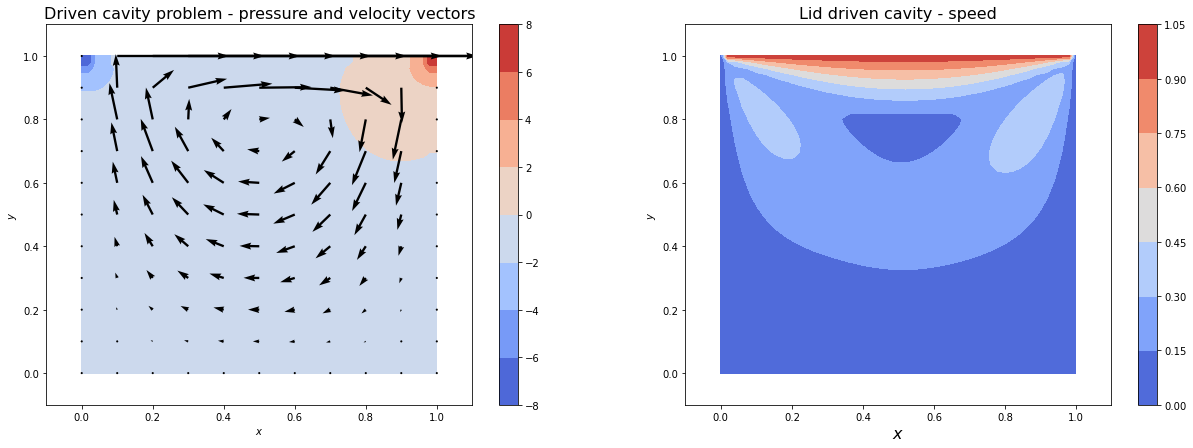

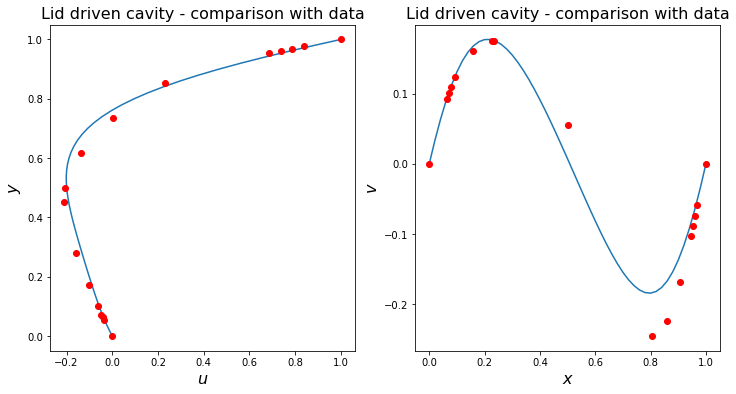

In [19]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,p, cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_title('Driven cavity problem - pressure and velocity vectors', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$')
ax1.set_title('Lid driven cavity - speed', fontsize=16)


fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.plot(u[int(np.shape(u)[0]/2),:],Y[int(np.shape(u)[0]/2),:])
ax1.plot(Ghia_Re100_u[:,1],Ghia_Re100_u[:,0],'ro')
ax1.set_xlabel('$u$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Lid driven cavity - comparison with data', fontsize=16)
ax1 = fig.add_subplot(122)
ax1.plot(X[:,int(np.shape(u)[0]/2)],v[:,int(np.shape(u)[0]/2)])
ax1.plot(Ghia_Re100_v[:,0],Ghia_Re100_v[:,1],'ro')
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$v$', fontsize=16)
ax1.set_title('Lid driven cavity - comparison with data', fontsize=16)

